# IAB303 - Assessment Task 2
## TOWS analysis report

#### INSTRUCTIONS

1. Complete the section below with your personal details (and run the cell)
2. Choose to use either the supplied scenario OR your own scenario. If selecting your own, check suitability with teaching team. If using the supplied scenario, use the provided internal data. You may supplement this with additional data as required.
3. Ensure that you include at least 1 complete analysis using *internal* data
4. Ensure that you include at least 1 complete analysis using *external* data
5. Ensure that you include at least 1 actionable recommendation from a TOWS analysis using your data analytics from steps 3 & 4.
6. Ensure that you use markdown cells to document your thinking and decision making for each stage of the process. Be clear on how your decisions are working towards addressing the business concern.
7. Ensure that you undertakee a peer review process and complete the peer review section
6. Before handing in your notebook, clear all cell outputs and run the complete notebook. Ensure that it runs without errors and that all output is displaying
7. Right-click on your notebook name (in file viewer) and select download. Ensure that your name and student ID are on the file, and then upload to the appropriate assignment upload link in blackboard.

In [157]:
# Complete the following cell with your details and run to produce your personalised header for this assignment

from IPython.core.display import display, HTML

first_name = "Cai"
last_name = "Liosatos"
student_number = "n10514295"

personal_header = "<h1>"+first_name+" "+last_name+" ("+student_number+")</h1>"
display(HTML(personal_header))

C:\Users\Cai Liosatos\AppData\Local\Temp\ipykernel_2604\647116755.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [158]:
# import libraries needed for this notebook here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import urllib.request
import json
import os
import os.path
import re

cache_on = False

## Executive Summary:


The client is a not-for-profit organisation offering residential aged care services within Brisbane. They are curious as to the most efficient spending strategy of recently accrued funding to you maximise their companies gains from said spending.  To complete this task, information regarding the following areas will be acquired and analysed: <br />
-	the community’s understanding of the needs of the sector <br />
-	the potential impact of government action <br />
-	their own influence sphere within the sector <br />

This information is pertinent to our client as it provides them an insight as to potential areas they can improve internally, as well as potential external impacts dictating societies opinions and perspectives on the industry and any forthcoming outcomes from these. Cross correlating the internal and external insights provides our client with a road map for future improvement.

## Introduction:

### Business Concern:
The client is concerned about present factors in the sector they work in, and are wishing or an analysis to be conducted regarding a number of areas, as follows: <br />
-	the community’s understanding of the needs of the sector <br />
-	the potential impact of government action <br />
-	their own influence sphere within the sector <br />

They want to wholly understand each of these three aspects and wish to enhance or improve these areas with their own company. They are also looking to analyse the strengths and weaknesses in their service area, and potential opportunities or threats from external factors that could affect them.  

### Stakeholders:

The only directly relevant stakeholder to this analysis is the client themselves. However, parties such as the source of their newly acquired funding, legislative bodies, or other external parties interested in our client would also be classed as a stakeholder.

### Questions:

Through analysing external data from multiple sources (the guardian API, and anonymous survey from willing unrelated participants), what are some potential opportunities or threats that could impact our client either positively or negatively; and how and they be taken advantage of or remedied

Through analysing data obtained internally (CSV containing reports of aged care facilities), what are some potential strengths or weaknesses impacting our client either positively or negatively; and how can they be taken advantage of or remedied


## Body:

### Acquiring Data:

#### External Data:

##### Create functions to complete repetitive code (in this case, caching API pulling and HTML scraping)

functions for caching API search results for local use

In [159]:
# function to create a cached file containing the page pulled from the API
def cache_save(folder_url, current_page, cache_list):
    np.save(folder_url+str(current_page)+".npy", cache_list, allow_pickle=True, fix_imports=True)

# function to load the cached files into a list
def cache_load(folder_url):
# loading cache
    if os.path.exists(folder_url):
        loaded_cache = []
        for file in os.listdir(folder_url):
            loaded_cache.append(np.load(folder_url+file, allow_pickle=True).tolist())
        new_cache_list = flatten_list(loaded_cache)
        return new_cache_list

# function to flatten list of cached lists into a singular list
def flatten_list(cache_list):
    flat_list = []
    # Iterate through the outer list
    for element in cache_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

In [160]:
# calling the api URL to get the total page count
def page_count(api_url_start, api_url_end):
    error_counter = 0
    while error_counter < 3:
        api_url = api_url_start + "1" + api_url_end
        content = requests.get(api_url)
        api_data = json.loads(content.content)
        if api_data['response']['status'] == "ok":
            page_count = int(api_data['response']['pages'])
            break
        else:
            error_counter += 1
    page_count = "API has errored three times in a row whilst trying to get page count, check if the URL is correct" if error_counter >= 3 else page_count
    return page_count

#  function to scrape the data from the page returned from the api into a list
def api_scraping(page_count, url_start, url_end, folder_url):
    error_msg = []
    error_counter = 0
    current_page = 1
    results_list = []
# while loop to add outputs to a list
    while current_page <= page_count:
        if error_counter < 3:
            cache_list = []
            api_url = url_start + str(current_page) + url_end
            content = requests.get(api_url)
            api_data = json.loads(content.content)
            if api_data['response']['status'] == "error":
                error_msg.append(api_data['response']['message'])
                error_counter += 1
            else:
                for item in api_data['response']['results']:
                    cache_list.append(item)
                    results_list.append(item)
        
                # caching results for local use
                if cache_on:
                    cache_save(folder_url, current_page, cache_list)
                current_page += 1
                error_counter = 0
                error_msg = []
        else:
            error_msg.append("API has errored three times in a row, giving up")
            break
    return results_list, error_msg

# Clean up dataframe to be more visually appealing, and easier to use
def df_creation(dataframe_name):
    dataframe_name = dataframe_name.rename(columns = {'id':'ID', 'type':'Type', 'sectionId':'SectionID', 'sectionName':'Section Name', 'webPublicationDate':'Web Publication Date', 'webTitle':'Web Title', 'webUrl':'URL', 'apiUrl':'API URL', 'isHosted':'Is Hosted', 'pillarId': 'Pillar ID', 'pillarName':'Pillar Name'}).copy()
    # clean the data to be more user friendly
    if "Web Publication Date" in dataframe_name.columns:
        dataframe_name["Web Publication Date"] = dataframe_name["Web Publication Date"].apply(lambda x: x.replace("T", " ").replace("Z", ""))
        if dataframe_name["Web Publication Date"].dtype == object:
            dataframe_name["Web Publication Date"] = pd.to_datetime(dataframe_name["Web Publication Date"], format="%Y-%m-%d %H:%M:%S")
        dataframe_name.sort_values(by='Web Publication Date', ascending=False, inplace=True)
        dataframe_name["Month"] = dataframe_name["Web Publication Date"].dt.month
        dataframe_name["Year"] = dataframe_name["Web Publication Date"].dt.year
    if "Pillar ID" in dataframe_name.columns:
        dataframe_name["Pillar ID"] = dataframe_name["Pillar ID"].astype(str).apply(lambda x: x.replace("pillar/", ""))
    
    return dataframe_name

def duplicate_check(original_df):
    master_list = []
    result_list = []
    for index, row in original_df.iterrows():
        dynamic_map = {}
        dynamic_map["ID"] = row["ID"]
        dynamic_map["Type"] = row["Type"]
        dynamic_map["SectionID"] = row["SectionID"]
        dynamic_map["Section Name"] = row["Section Name"]
        dynamic_map["Web Publication Date"] = row["Web Publication Date"]
        dynamic_map["Web Title"] = row["Web Title"]
        dynamic_map["URL"] = row["URL"]
        dynamic_map["API URL"] = row["API URL"]
        dynamic_map["Is Hosted"] = row["Is Hosted"]
        dynamic_map["Pillar ID"] = row["Pillar ID"]
        dynamic_map["Pillar Name"] = row["Pillar Name"]
        dynamic_map["Month"] = row["Month"]
        dynamic_map["Year"] = row["Year"]
        result_list.append(dynamic_map)

    for item in range(len(result_list)):
        if result_list[item] not in master_list:
            master_list.append(result_list[item])  

    new_df = pd.DataFrame(master_list)
    return new_df

functions for HTML, and cleaning the constructed DF

In [161]:
def df_cleaning(df):
    if df["Date"].dtype == object:
        df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d %H:%M:%S")
    df.sort_values(by='Date', ascending=False, inplace=True)
    
    if "Month" not in df.columns:
        df["Month"] = df["Date"].dt.month
    if "Year" not in df.columns:
        df["Year"] = df["Date"].dt.year
    return df

# Get HTML function
def get_HTML(url):
    response = requests.get(url)
    html = response.text
    return html

# Beautiful soup function for subtitle
def extract_subTitle(HTML):
    soup = BeautifulSoup(HTML, "html.parser") # the html input and the parser name
    article = soup.find("main") # the tag that contains the article
    div_element = article.find("div", attrs={"data-gu-name": "standfirst"}) # the tag that can be found using an attribute
    target_element = div_element.find("p")
    if target_element:
        return target_element.text
    else:
        return '-'

# Beautiful soup function for live articles
def parse_article(article, temp_result):
    fig_element = article.find("figure")
    if fig_element:
        temp_result = ''
    else:
        for child in article.children:   
            if child.name == 'p':
                temp_result += child.text + '\n'
            if child.name == 'ul':
                for li in child.findAll('li'):
                    if li.find('ul'):
                        break
                    temp_result += li.text + '\n'
        temp_result += '\n'
    return temp_result

# Beautiful soup function for body
def extract_body(HTML):
    result = ""
    soup = BeautifulSoup(HTML, "html.parser") # the html input and the parser name

    news = soup.find("main", attrs={"data-layout": "LiveLayout"})
    if news:
        div_element = news.find("div", attrs={"id": "liveblog-body"}) # the tag that can be found using an attribute
        div_art_element = div_element.findAll("article")
        for item in div_art_element:
            temp_result = ''
            temp_result = parse_article(item, temp_result)
            result += temp_result
    else:
        news = soup.find("main") # the tag that contains the article
        div_element = news.find("div", attrs={"id": "maincontent"}) # the tag that can be found using an attribute
        div_div_element = div_element.find("div")
        target_elements = div_element.findAll("p")
        for te in target_elements:
            result += te.text + '\n'*2
            
    return result

def scraping_df(df):
    if not os.path.exists('web-scraped-data.csv'):
        results_data_list = []

        for index, row in df.iterrows():
            dynamic_map = {}
            dynamic_map["Date"] = row["Web Publication Date"]
            dynamic_map["Section"] = row["Section Name"]
            dynamic_map["Title"] = row["Web Title"]
            dynamic_map["Subtitle"] = extract_subTitle(get_HTML(row["URL"]))
            dynamic_map["Body"] = extract_body(get_HTML(row["URL"]))

            results_data_list.append(dynamic_map)
            
        scraped_data_df = df_cleaning(pd.DataFrame(results_data_list))
        scraped_data_df.to_csv('web-scraped-data.csv')
        
    else:
        scraped_data_df = pd.read_csv('web-scraped-data.csv')
        del scraped_data_df["Unnamed: 0"]
        scraped_data_df = scraped_data_df.replace(np.nan, '', regex=True)
    
    return scraped_data_df

##### Code utilising the created functions to acquire the relevant data for analysis

pulling results from TheGuardian api from 2017 onwards under the search condition of "Aged care facility" (takes up to 30 seconds)

In [162]:
# setting important variables
aged_care_results = []
aged_care_api_url_start = "https://content.guardianapis.com/search?from-date=2017-01-01&to-date=2022-10-05&order-by=newest&page="
aged_care_api_url_end = "&page-size=50&q=%22Aged%20care%20facility%22&api-key=dd3e21c9-be37-4bdb-b311-2fd86c0fd153"

# getting the total page count
aged_care_page_count = page_count(aged_care_api_url_start, aged_care_api_url_end)
# making the cache folder directory
if cache_on:
    if os.path.exists("./cache/Aged-Care-Facility/") is False:
        os.makedirs("./cache/Aged-Care-Facility/")

# printing first result of data if no errors, else printing the error (formatted)
if type(aged_care_page_count) == int:
    aged_care_results, error_msg = api_scraping(aged_care_page_count, aged_care_api_url_start, aged_care_api_url_end, "./cache/Aged-Care-Facility/")
    print(f"{error_msg[3]}\n\nThese were the error messages:\n1: {error_msg[0]}\n2: {error_msg[1]}\n3: {error_msg[2]}\n\nMake sure the URL is correct, then try again") if len(error_msg) > 3 else print(aged_care_results[0])
else:
    print(aged_care_page_count)



# 'https://content.guardianapis.com/search?from-date=2017-01-01&to-date=2022-10-05&order-by=newest&page=1&page-size=50&q=%22Aged%20care%20facility%22&api-key=dd3e21c9-be37-4bdb-b311-2fd86c0fd153'

{'id': 'australia-news/live/2022/sep/28/australia-politics-live-anti-corruption-bill-mark-dreyfus-petrol-excise-tax-anthony-albanese-optus-data-hack-cyber-security', 'type': 'liveblog', 'sectionId': 'australia-news', 'sectionName': 'Australia news', 'webPublicationDate': '2022-09-28T08:54:58Z', 'webTitle': 'Labor MP says Coalition partly to blame for telco hack – as it happened', 'webUrl': 'https://www.theguardian.com/australia-news/live/2022/sep/28/australia-politics-live-anti-corruption-bill-mark-dreyfus-petrol-excise-tax-anthony-albanese-optus-data-hack-cyber-security', 'apiUrl': 'https://content.guardianapis.com/australia-news/live/2022/sep/28/australia-politics-live-anti-corruption-bill-mark-dreyfus-petrol-excise-tax-anthony-albanese-optus-data-hack-cyber-security', 'isHosted': False, 'pillarId': 'pillar/news', 'pillarName': 'News'}


In [163]:
# loading cache
if cache_on:
    aged_care_results = cache_load("./cache/Aged-Care-Facility/")

In [164]:
ac_df = df_creation(pd.DataFrame(aged_care_results))
ac_df

,ID,Type,SectionID,Section Name,Web Publication Date,Web Title,URL,API URL,Is Hosted,Pillar ID,Pillar Name,Month,Year
0,australia-news/live/2022/sep/28/australia-poli...,liveblog,australia-news,Australia news,2022-09-28 08:54:58,Labor MP says Coalition partly to blame for te...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
1,australia-news/live/2022/sep/17/australia-news...,liveblog,australia-news,Australia news,2022-09-17 07:58:57,Government tries to block rail union action; P...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
2,australia-news/2022/sep/13/as-covid-crippled-a...,article,australia-news,Australia news,2022-09-12 17:30:42,As Covid crippled aged care sector only 30 ADF...,https://www.theguardian.com/australia-news/202...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
3,australia-news/live/2022/sep/03/qantas-boss-wa...,liveblog,australia-news,Australia news,2022-09-03 08:00:22,More than 30 people died due to triple-zero de...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
4,australia-news/2022/aug/08/plans-for-retiremen...,article,australia-news,Australia news,2022-08-07 17:30:04,Plans for retirement village in Brisbane area ...,https://www.theguardian.com/australia-news/202...,https://content.guardianapis.com/australia-new...,False,news,News,8,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,australia-news/2017/oct/17/the-artists-paintin...,article,australia-news,Australia news,2017-10-16 17:00:05,The artists painting their Indigenous songline...,https://www.theguardian.com/australia-news/201...,https://content.guardianapis.com/australia-new...,False,news,News,10,2017
421,australia-news/2017/aug/23/the-answers-in-the-...,article,australia-news,Australia news,2017-09-07 09:45:17,Australian marriage equality vote explainer – ...,https://www.theguardian.com/australia-news/201...,https://content.guardianapis.com/australia-new...,False,news,News,9,2017
422,commentisfree/2017/aug/17/religious-freedom-is...,article,commentisfree,Opinion,2017-08-17 01:36:06,Religious freedom is an important right. Once ...,https://www.theguardian.com/commentisfree/2017...,https://content.guardianapis.com/commentisfree...,False,opinion,Opinion,8,2017
423,society/2017/apr/11/qanda-81-year-old-calls-eu...,article,society,Society,2017-04-10 21:06:41,Q&A: 81-year-old audience member calls euthana...,https://www.theguardian.com/society/2017/apr/1...,https://content.guardianapis.com/society/2017/...,False,news,News,4,2017


pulling results from TheGuardian api from 2017 onwards under the search condition of "residential aged care" (takes up to 30 seconds)

In [165]:
# setting important variables
residential_care_results = []
residential_care_api_url_start = "https://content.guardianapis.com/search?from-date=2017-01-01&to-date=2022-10-05&order-by=newest&page="
residential_care_api_url_end = "&page-size=50&q=%22Residential%20Aged%20Care%22&api-key=dd3e21c9-be37-4bdb-b311-2fd86c0fd153"

# getting the total page count
residential_care_page_count = page_count(residential_care_api_url_start, residential_care_api_url_end)

# making the cache folder directory
if cache_on:
    if os.path.exists("./cache/Aged-Care-Facility/") is False:
        os.makedirs("./cache/Residential-Aged-Care/")

# printing first result of data if no errors, else printing the error (formatted)
if type(residential_care_page_count) == int:
    residential_care_results, error_msg = api_scraping(residential_care_page_count, residential_care_api_url_start, residential_care_api_url_end, "./cache/Residential-Aged-Care/")
    print(f"{error_msg[3]}\n\nThese were the error messages:\n1: {error_msg[0]}\n2: {error_msg[1]}\n3: {error_msg[2]}\n\nMake sure the URL is correct, then try again") if len(error_msg) > 3 else print(residential_care_results[0])
else:
    print(residential_care_page_count)


# 'https://content.guardianapis.com/search?from-date=2017-01-01&to-date=2022-10-05&order-by=newest&page=1&page-size=50&q=%22Residential%20Aged%20Care%22&api-key=dd3e21c9-be37-4bdb-b311-2fd86c0fd153'

{'id': 'commentisfree/2022/oct/01/ending-mandatory-isolation-does-not-mean-covid-is-over-but-we-need-to-move-beyond-short-term-fixes', 'type': 'article', 'sectionId': 'commentisfree', 'sectionName': 'Opinion', 'webPublicationDate': '2022-10-01T02:32:51Z', 'webTitle': 'Ending mandatory isolation does not mean Covid is over. But we need to move beyond short-term fixes | Catherine Bennett', 'webUrl': 'https://www.theguardian.com/commentisfree/2022/oct/01/ending-mandatory-isolation-does-not-mean-covid-is-over-but-we-need-to-move-beyond-short-term-fixes', 'apiUrl': 'https://content.guardianapis.com/commentisfree/2022/oct/01/ending-mandatory-isolation-does-not-mean-covid-is-over-but-we-need-to-move-beyond-short-term-fixes', 'isHosted': False, 'pillarId': 'pillar/opinion', 'pillarName': 'Opinion'}


In [166]:
# loading cache
if cache_on:
    residential_care_results = cache_load("./cache/Residential-Aged-Care/")

In [167]:
rc_df = df_creation(pd.DataFrame(residential_care_results))
rc_df

,ID,Type,SectionID,Section Name,Web Publication Date,Web Title,URL,API URL,Is Hosted,Pillar ID,Pillar Name,Month,Year
0,commentisfree/2022/oct/01/ending-mandatory-iso...,article,commentisfree,Opinion,2022-10-01 02:32:51,Ending mandatory isolation does not mean Covid...,https://www.theguardian.com/commentisfree/2022...,https://content.guardianapis.com/commentisfree...,False,opinion,Opinion,10,2022
1,australia-news/2022/sep/24/grim-milestone-as-a...,article,australia-news,Australia news,2022-09-24 00:30:49,Grim milestone as Australia’s aged care homes ...,https://www.theguardian.com/australia-news/202...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
2,australia-news/2022/sep/20/australian-governme...,article,australia-news,Australia news,2022-09-19 17:30:06,Australian government faces biggest class acti...,https://www.theguardian.com/australia-news/202...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
3,australia-news/live/2022/sep/17/australia-news...,liveblog,australia-news,Australia news,2022-09-17 07:58:57,Government tries to block rail union action; P...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
4,commentisfree/2022/sep/15/australians-might-be...,article,commentisfree,Opinion,2022-09-15 02:15:18,Australians might be ‘living with Covid’ but a...,https://www.theguardian.com/commentisfree/2022...,https://content.guardianapis.com/commentisfree...,False,opinion,Opinion,9,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,australia-news/live/2017/aug/08/coalition-join...,liveblog,australia-news,Australia news,2017-08-08 08:14:56,Malcolm Roberts under pressure on citizenship ...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,8,2017
388,sustainable-business/2017/jun/28/always-grasp-...,article,sustainable-business,Guardian Sustainable Business,2017-06-28 02:37:19,'Always grasp the opportunity': confronting ag...,https://www.theguardian.com/sustainable-busine...,https://content.guardianapis.com/sustainable-b...,False,nan,NaN,6,2017
389,world/2017/jun/20/tuesday-briefing-deadly-real...,article,world,World news,2017-06-20 05:25:47,Tuesday briefing: Deadly reality of Islamophob...,https://www.theguardian.com/world/2017/jun/20/...,https://content.guardianapis.com/world/2017/ju...,False,news,News,6,2017
390,world/2017/mar/25/the-coming-back-out-ball-how...,article,world,World news,2017-03-24 21:36:50,The Coming Back Out Ball: being out and proud ...,https://www.theguardian.com/world/2017/mar/25/...,https://content.guardianapis.com/world/2017/ma...,False,news,News,3,2017


Combining the two dataframes (as they are of the same overall topic), and removing any duplicate entries, as this could create misinformation in the analysis

In [168]:
# combine the two dataframes together, removing duplicate entires
final_api_data = duplicate_check(pd.concat([ac_df, rc_df]))
final_api_data

,ID,Type,SectionID,Section Name,Web Publication Date,Web Title,URL,API URL,Is Hosted,Pillar ID,Pillar Name,Month,Year
0,australia-news/live/2022/sep/28/australia-poli...,liveblog,australia-news,Australia news,2022-09-28 08:54:58,Labor MP says Coalition partly to blame for te...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
1,australia-news/live/2022/sep/17/australia-news...,liveblog,australia-news,Australia news,2022-09-17 07:58:57,Government tries to block rail union action; P...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
2,australia-news/2022/sep/13/as-covid-crippled-a...,article,australia-news,Australia news,2022-09-12 17:30:42,As Covid crippled aged care sector only 30 ADF...,https://www.theguardian.com/australia-news/202...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
3,australia-news/live/2022/sep/03/qantas-boss-wa...,liveblog,australia-news,Australia news,2022-09-03 08:00:22,More than 30 people died due to triple-zero de...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,9,2022
4,australia-news/2022/aug/08/plans-for-retiremen...,article,australia-news,Australia news,2022-08-07 17:30:04,Plans for retirement village in Brisbane area ...,https://www.theguardian.com/australia-news/202...,https://content.guardianapis.com/australia-new...,False,news,News,8,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,commentisfree/2017/oct/31/reports-of-poor-stan...,article,commentisfree,Opinion,2017-10-31 04:10:23,Reports of poor standards in aged care are jus...,https://www.theguardian.com/commentisfree/2017...,https://content.guardianapis.com/commentisfree...,False,opinion,Opinion,10,2017
692,australia-news/live/2017/aug/08/coalition-join...,liveblog,australia-news,Australia news,2017-08-08 08:14:56,Malcolm Roberts under pressure on citizenship ...,https://www.theguardian.com/australia-news/liv...,https://content.guardianapis.com/australia-new...,False,news,News,8,2017
693,sustainable-business/2017/jun/28/always-grasp-...,article,sustainable-business,Guardian Sustainable Business,2017-06-28 02:37:19,'Always grasp the opportunity': confronting ag...,https://www.theguardian.com/sustainable-busine...,https://content.guardianapis.com/sustainable-b...,False,nan,NaN,6,2017
694,world/2017/jun/20/tuesday-briefing-deadly-real...,article,world,World news,2017-06-20 05:25:47,Tuesday briefing: Deadly reality of Islamophob...,https://www.theguardian.com/world/2017/jun/20/...,https://content.guardianapis.com/world/2017/ju...,False,news,News,6,2017


using web scraping to retrieve certain aspects of the acquired theguardian articles

In [169]:
final_scrape_df = scraping_df(final_api_data)
final_scrape_df

,Date,Section,Title,Subtitle,Body,Month,Year
0,2022-10-01 02:32:51,Opinion,Ending mandatory isolation does not mean Covid...,The virus is here to stay and we have to find ...,Changes in Covid-19 policy settings always inv...,10,2022
1,2022-09-28 08:54:58,Australia news,Labor MP says Coalition partly to blame for te...,Federal government believes the company should...,Anthony Albanese then takes a dixer on the Opt...,9,2022
2,2022-09-24 00:30:49,Australia news,Grim milestone as Australia’s aged care homes ...,Deadliest year of the pandemic so far has seen...,The Covid-19 pandemic may have slipped from th...,9,2022
3,2022-09-19 17:30:06,Australia news,Australian government faces biggest class acti...,Class action alleging exclusion from disabilit...,The Australian government is facing a massive ...,9,2022
4,2022-09-17 07:58:57,Australia news,Government tries to block rail union action; P...,Flood warnings in place for parts of Australia...,And that’s where we’ll leave you this evening....,9,2022
...,...,...,...,...,...,...,...
691,2017-06-28 02:37:19,Guardian Sustainable Business,'Always grasp the opportunity': confronting ag...,More Australians are rejecting the negativity ...,Eileen Kramer is reinventing ageing. The 102-y...,6,2017
692,2017-06-20 05:25:47,World news,Tuesday briefing: Deadly reality of Islamophob...,Theresa May vows to tackle all forms of violen...,"Good morning, it’s Warren Murray with your Bri...",6,2017
693,2017-04-10 21:06:41,Society,Q&A: 81-year-old audience member calls euthana...,Patricia Fellows responds bluntly to bioethics...,"Leaning forward in her seat, 81-year-old Patri...",4,2017
694,2017-03-24 21:36:50,World news,The Coming Back Out Ball: being out and proud ...,Monthly dance classes in a Melbourne hall are ...,A bald man in sparkling gold hot pants and avi...,3,2017


Pulling the data from the provided external anonymous survey csv

In [170]:
survey_df = pd.read_csv('for-release-community-attitudes-survey.csv', low_memory=False)
survey_df

,id,weight,SCR1,SCR3,HQGender,hqareatypex,Age Bracket,HQHouseIncome,Q2_A,Q2_B,...,Q34_19,Q36,Q36_1_other,Q37,Q38,Q40A,Q40A_1_other,Q40B,SEIFA_SCORE,SEIFA_DECILE
0,1,1.712897,1,2,2,2,3,8,NaN,NaN,...,0,1,40.0,4,2,1,2.0,1.0,1096,10
1,2,1.136831,1,2,1,2,6,10,NaN,NaN,...,0,1,10.0,4,2,1,2.0,1.0,1096,10
2,3,1.136831,1,2,1,2,6,12,2.0,1.0,...,0,1,70.0,4,2,1,2.0,1.0,1096,10
3,4,1.712897,1,3,2,2,3,9,2.0,1.0,...,0,1,50.0,4,2,1,2.0,1.0,1096,10
4,5,1.930605,1,2,1,2,8,9,2.0,1.0,...,0,99,NaN,4,2,1,2.0,1.0,1096,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10513,10514,2.697533,1,3,1,2,4,8,2.0,1.0,...,0,1,15.0,4,2,1,2.0,1.0,NaN,NaN
10514,10515,0.430757,1,2,2,3,7,98,2.0,1.0,...,0,99,NaN,1,2,1,1.0,NaN,NaN,NaN
10515,10516,2.151093,1,2,1,3,5,7,NaN,NaN,...,0,1,100.0,4,2,1,4.0,2.0,NaN,NaN
10516,10517,0.904556,1,2,2,3,6,5,NaN,NaN,...,0,99,NaN,4,2,1,2.0,1.0,NaN,NaN


#### Internal Data: 

##### Create functions to complete repetitive code (in this case, iterating over CSV's, cleaning up some values) 


In [171]:
def data_iterating(df):
    service_size_map = {1: "1-20", 2: "21-40", 3: "41-60", 4: "61-80", 5: "81-100", 6: "101+"}

    for index, row in df.iterrows():
        if "Service_size" in df.keys():
            df.loc[df["Service_size"] == row["Service_size"], "Service_size"] = re.sub(r'[^\w\d\-\=\!\@\#\$\%\^\&\*\(\)\_\+\.]', "-", row["Service_size"])
        else:
            df.loc[df["SERVICE_SIZE"] == row["SERVICE_SIZE"], "SERVICE_SIZE"] = service_size_map[row["SERVICE_SIZE"]]
            
    return df

##### Code utilising the created functions to acquire the relevant data for analysis

In [172]:
#
GEN_2021_data_df = data_iterating(pd.read_csv('ServicesPlaces_2020to2021_GENdata.csv'))
GEN_2021_data_df.columns = GEN_2021_data_df.columns.to_series().apply(lambda x: x.strip())
GEN_2021_data_df['Operational_places'] = pd.to_numeric(GEN_2021_data_df['Operational_places'], errors='coerce')
GEN_2021_data_df

,Year,State,ACPR_code,ACPR_name,REMOTENESS,MMM_code,Program_type,Organisation_type,Service_size,Operational_places
0,2021,NSW,101,Central Coast,Major Cities of Australia,1,Home care,Private,-,NaN
1,2021,NSW,101,Central Coast,Major Cities of Australia,1,Home care,Not-for-profit,-,NaN
2,2021,NSW,101,Central Coast,Major Cities of Australia,1,Home care,Private,-,NaN
3,2021,NSW,101,Central Coast,Major Cities of Australia,1,Home care,Private,-,NaN
4,2021,NSW,101,Central Coast,Major Cities of Australia,1,Home care,Not-for-profit,-,NaN
...,...,...,...,...,...,...,...,...,...,...
5750,2021,ACT,801,ACT,Major Cities of Australia,1,Residential care,Not-for-profit,41-60,42.0
5751,2021,ACT,801,ACT,Major Cities of Australia,1,Residential care,Private,101+,130.0
5752,2021,ACT,801,ACT,Major Cities of Australia,1,Residential care,Not-for-profit,101+,144.0
5753,2021,ACT,801,ACT,Major Cities of Australia,1,Residential care,Not-for-profit,61-80,80.0


In [173]:
GEN_2020_data_df = data_iterating(pd.read_csv('ServicesPlaces_2019to2020_GENdata.csv', encoding = 'cp1252'))
GEN_2020_data_df.columns = GEN_2020_data_df.columns.to_series().apply(lambda x: x.strip())
GEN_2020_data_df['Operational_places'] = pd.to_numeric(GEN_2020_data_df['Operational_places'], errors='coerce')
GEN_2020_data_df

,Year,State,ACPR_code,ACPR_name,Remoteness,MMM_code,Program_type,Organisation_type,Service_size,Operational_places
0,2020,NT,Unknown,Unknown,Unknown,Unknown,National Aboriginal and Torres Strait Islander...,Not-for-profit,41-60,58.0
1,2020,NSW,115,Southern Highlands,Inner Regional Australia,5,Multi-purpose service,Government,21-40,29.0
2,2020,NSW,115,Southern Highlands,Major Cities of Australia,1,Residential care,Not-for-profit,101+,126.0
3,2020,NSW,115,Southern Highlands,Major Cities of Australia,1,Home care,Not-for-profit,-,NaN
4,2020,NSW,115,Southern Highlands,Major Cities of Australia,1,Residential care,Private,101+,110.0
...,...,...,...,...,...,...,...,...,...,...
5770,2020,ACT,801,ACT,Major Cities of Australia,1,Residential care,Not-for-profit,41-60,42.0
5771,2020,ACT,801,ACT,Major Cities of Australia,1,Home care,Not-for-profit,-,NaN
5772,2020,ACT,801,ACT,Major Cities of Australia,1,Home care,Private,-,NaN
5773,2020,ACT,801,ACT,Major Cities of Australia,1,Home care,Private,-,NaN


In [174]:
GEN_2019_data_df = data_iterating(pd.read_csv('Services-and-places-in-aged-care-30-June-2019.csv', encoding = 'cp1252'))
GEN_2019_data_df

,YEAR,STATE,ACPR_CODE,ACPR_NAME,REMOTENESS,PROGRAM_TYPE,ORGANISATION_TYPE,SERVICE_SIZE,OPERATIONAL_PLACES
0,2019,NSW,113,South East Sydney,Major Cities of Australia,Residential care,Not-for-profit,101+,127
1,2019,NSW,114,South West Sydney,Inner Regional Australia,Residential care,Private,61-80,71
2,2019,NSW,109,New England,Outer Regional Australia,Residential care,Not-for-profit,41-60,57
3,2019,NSW,102,Central West,Outer Regional Australia,Residential care,Not-for-profit,21-40,37
4,2019,NSW,104,Hunter,Inner Regional Australia,Residential care,Not-for-profit,61-80,80
...,...,...,...,...,...,...,...,...,...
3252,2019,NSW,105,Illawarra,Inner Regional Australia,Residential care,Not-for-profit,61-80,64
3253,2019,NSW,114,South West Sydney,Major Cities of Australia,Residential care,Not-for-profit,101+,124
3254,2019,NSW,110,Northern Sydney,Major Cities of Australia,Residential care,Not-for-profit,101+,140
3255,2019,NSW,112,Riverina/Murray,Inner Regional Australia,Residential care,Not-for-profit,41-60,60


### Analysis:

#### External Analysis:

##### Create functions to complete repetitive code (in this case, searching through the DF's for keywords, and counting occurrence frequencies in dataframes)

Functions for keyword searching

In [175]:
# searches the inputted original list of data scraped from the API for the inputted keywords, then creates a new dataframe
def keyword_search(new_df, keywords, check):
    results_list = []
    master_list = []

    for index, row in new_df.iterrows():
        # defining variables for later use
        null_count = 0
        keyword_map = {}
        item_Date = row["Date"]
        item_Title = row["Title"]
        item_Subtitle = row["Subtitle"]
        item_Body = row["Body"]
        item_Month = row["Month"]
        item_Year = row["Year"]

        # searching for the keywords inputted
       
        for keyword in keywords:
            
            keyword_map[keyword] = item_Body.lower().count(keyword.lower())
            if keyword_map[keyword] == 0:
                null_count += 1
        dynamic_object = {}

        # setting column variables in dynamic_object dict based on found keywords
        dynamic_object["Date"] = item_Date
        dynamic_object["Title"] = item_Title
        dynamic_object["Subtitle"] = item_Subtitle
        dynamic_object["Body"] = item_Body
        dynamic_object["Month"] = item_Month
        dynamic_object["Year"] = item_Year

        if check:
            for keyword in keywords:
                dynamic_object[keyword] = keyword_map[keyword]
        # appending found articles to list
        if null_count < len(keywords):
            results_list.append(dynamic_object)

    # removing duplicate entries from list (function can be called using multiple dataframes, and will work dynamically)
    for item in range(len(results_list)):
        if results_list[item] not in master_list:
            master_list.append(results_list[item])
            
    # creating dataframe with found results
    master_df = pd.DataFrame(master_list)
    master_df.sort_values(by='Date', ascending=False, inplace=True)

    return master_df


Functions for counting the occurrence frequency of certain columns

In [176]:
# Function to create df containing the frequency of unique values in a given column in a given dataframe
def count_generator(df, col):
    list = []
    number = int(df[col].min())
    iterate_count = int(df[col].max()) - int(df[col].min()) + 1

    # iterate in the amount of the number of unique values
    for item in range(iterate_count):
        map = {}
        item_Month = number

        if number in df[col].values:
            item_Count = df[col].value_counts()[number]
        else:
            item_Count = 0

        # append values to object, then to list
        map[col] = item_Month
        map["Count"] = item_Count
        list.append(map)
        number +=1
    new_df = pd.DataFrame(list)
    return new_df

def multi_column_counter(df):
    list = []
    number = 1
    
    for item in range(12):
        map = {}
        item_Month = number
        
        if number in df["Month"].values:
            df2 = df[(df["Month"] == number)]
            item_death = df2['death'].sum()
            item_covid = df2['covid'].sum()
            item_corona = df2['corona'].sum()
            item_increase = df2['increase'].sum()
            item_staff = df2['staff'].sum()
            item_laws = df2['laws'].sum()
            item_legislat = df2['legislat'].sum()
        else:
            item_death = 0
            item_covid = 0
            item_corona = 0
            item_increase = 0
            item_staff = 0
            item_laws = 0
            item_legislat = 0

        # append values to object, then to list
        map["Month"] = number
        map["death"] = item_death
        map["covid"] = item_covid
        map["corona"] = item_corona
        map["increase"] = item_increase
        map["staff"] = item_staff
        map["laws"] = item_laws
        map["legislat"] = item_legislat
        list.append(map)
        number +=1
    return pd.DataFrame(list)


Function for analysing the survey, creating a list of output dataframes for analysis purposes

In [177]:
def survey_analysis(df, questions, questions_answers, gender):
    df_list = []
    age_map = {1: "Under 18", 2: "18-24", 3: "25-34", 4: "35-44", 5: "45-54", 6: "55-64", 7: "65-69", 8: "70-79", 9: "80-89", 10: "90 or older", 99: "Prefer not to say"}
    for question in questions:
        index = questions.index(question)        
        result_list = []
        for answer in list(range(questions_answers[index][0], questions_answers[index][1] + 1)):
            dynamic_map = {} 
            dynamic_map["Answers"] = answer
            for k, v in age_map.items():
                dynamic_map[v] = len(df.loc[(df[question] == answer) & (df["Age Bracket"] == k) & (df["HQGender"] == gender)])
            result_list.append(dynamic_map)
        df_list.append(pd.DataFrame(result_list))
        
    return df_list

##### Code utilising the created functions to analyse the acquired data

checking scraped results for relevant keywords

In [178]:
keywords_df1 = keyword_search(final_scrape_df, ["death", "covid", "corona", "increase", "staff", "laws", "legislat"], True)

keywords_df1

,Date,Title,Subtitle,Body,Month,Year,death,covid,corona,increase,staff,laws,legislat
0,2022-10-01 02:32:51,Ending mandatory isolation does not mean Covid...,The virus is here to stay and we have to find ...,Changes in Covid-19 policy settings always inv...,10,2022,9,10,0,0,2,0,0
1,2022-09-28 08:54:58,Labor MP says Coalition partly to blame for te...,Federal government believes the company should...,Anthony Albanese then takes a dixer on the Opt...,9,2022,0,0,0,0,0,0,2
2,2022-09-24 00:30:49,Grim milestone as Australia’s aged care homes ...,Deadliest year of the pandemic so far has seen...,The Covid-19 pandemic may have slipped from th...,9,2022,10,12,0,2,6,0,0
3,2022-09-15 02:15:18,Australians might be ‘living with Covid’ but a...,"As our nation mourns the Queen, I wonder who i...","Around Australia, thousands of people are mour...",9,2022,3,8,0,1,4,0,0
4,2022-09-13 08:54:58,Mixed reaction on potential delay to integrity...,-,And that’s where we’ll leave you this evening....,9,2022,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,2017-08-17 01:36:06,Religious freedom is an important right. Once ...,I’ll be pleased when marriage equality is reco...,"Countries such as the US, the UK, New Zealand ...",8,2017,0,0,0,0,0,4,4
665,2017-06-20 05:25:47,Tuesday briefing: Deadly reality of Islamophob...,Theresa May vows to tackle all forms of violen...,"Good morning, it’s Warren Murray with your Bri...",6,2017,2,0,0,0,0,0,0
666,2017-04-10 21:06:41,Q&A: 81-year-old audience member calls euthana...,Patricia Fellows responds bluntly to bioethics...,"Leaning forward in her seat, 81-year-old Patri...",4,2017,7,0,0,0,0,3,1
667,2017-03-24 21:36:50,The Coming Back Out Ball: being out and proud ...,Monthly dance classes in a Melbourne hall are ...,A bald man in sparkling gold hot pants and avi...,3,2017,1,0,0,0,6,0,2


In [179]:
keywords_df2 = keyword_search(final_scrape_df, ["death", "covid", "corona", "increase", "staff", "laws", "legisla"], False)

keywords_df2

,Date,Title,Subtitle,Body,Month,Year
0,2022-10-01 02:32:51,Ending mandatory isolation does not mean Covid...,The virus is here to stay and we have to find ...,Changes in Covid-19 policy settings always inv...,10,2022
1,2022-09-28 08:54:58,Labor MP says Coalition partly to blame for te...,Federal government believes the company should...,Anthony Albanese then takes a dixer on the Opt...,9,2022
2,2022-09-24 00:30:49,Grim milestone as Australia’s aged care homes ...,Deadliest year of the pandemic so far has seen...,The Covid-19 pandemic may have slipped from th...,9,2022
3,2022-09-15 02:15:18,Australians might be ‘living with Covid’ but a...,"As our nation mourns the Queen, I wonder who i...","Around Australia, thousands of people are mour...",9,2022
4,2022-09-13 08:54:58,Mixed reaction on potential delay to integrity...,-,And that’s where we’ll leave you this evening....,9,2022
...,...,...,...,...,...,...
664,2017-08-17 01:36:06,Religious freedom is an important right. Once ...,I’ll be pleased when marriage equality is reco...,"Countries such as the US, the UK, New Zealand ...",8,2017
665,2017-06-20 05:25:47,Tuesday briefing: Deadly reality of Islamophob...,Theresa May vows to tackle all forms of violen...,"Good morning, it’s Warren Murray with your Bri...",6,2017
666,2017-04-10 21:06:41,Q&A: 81-year-old audience member calls euthana...,Patricia Fellows responds bluntly to bioethics...,"Leaning forward in her seat, 81-year-old Patri...",4,2017
667,2017-03-24 21:36:50,The Coming Back Out Ball: being out and proud ...,Monthly dance classes in a Melbourne hall are ...,A bald man in sparkling gold hot pants and avi...,3,2017


creating lists of new DFs only containing relevant information for analysis

In [180]:
year_keywords_list = []
year_keywords_count_list = []
for i in range(int(final_scrape_df["Year"].min()), int(final_scrape_df["Year"].max())+1):
    keywords_df = keywords_df1.loc[keywords_df1['Year'] == i].sort_values(by="Month", ascending=True)
    year_keywords_list.append(keywords_df)
    year_keywords_count_list.append(multi_column_counter(keywords_df))

In [181]:
year_df_list = []
year_count_list = []
for i in range(int(final_scrape_df["Year"].min()), int(final_scrape_df["Year"].max())+1):
    year_df = keywords_df1.loc[keywords_df1['Year'] == i].sort_values(by="Month", ascending=True)
    year_df_list.append(keywords_df)
    year_count_list.append(count_generator(year_df, "Month"))

##### Analysis of data from survey

In [182]:
questions_list = ["Q2_I", "Q3", "Q18_C", "Q18_D", "Q20_B", "Q26_C", "Q27", "Q32A_A", "Q32A_B", "Q32A_C", "Q32A_D", "Q32A_E", "Q32A_F", "Q32A_G", "Q32A_H", "Q32A_I", "Q32A_J", "Q32b_A", "Q32b_B", "Q32b_C", "Q32b_D", "Q32b_E", "Q32b_F", "Q32b_G", "Q32b_H", "Q32b_I", "Q32b_J", "Q36"]
questions_answers_list = [[1, 3], [1, 5], [1, 3], [1, 3], [1, 3], [1, 3], [1, 13], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 99]] 
survey_male_analysis_df_list = survey_analysis(survey_df, questions_list, questions_answers_list, 1)
survey_female_analysis_df_list = survey_analysis(survey_df, questions_list, questions_answers_list, 2)

survey_analysis_df_list = [survey_male_analysis_df_list, survey_female_analysis_df_list]

After further analysing the survey, what were the responses for Q36?

In [183]:
age_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 99]
for age in age_list:
    print(f'age response number: {age}')
    print(survey_df["Q36"].loc[(survey_df["HQGender"] == 1) & (survey_df["Age Bracket"] == 2)].value_counts())
    print()


age response number: 1
1     400
99     50
Name: Q36, dtype: int64

age response number: 2
1     400
99     50
Name: Q36, dtype: int64

age response number: 3
1     400
99     50
Name: Q36, dtype: int64

age response number: 4
1     400
99     50
Name: Q36, dtype: int64

age response number: 5
1     400
99     50
Name: Q36, dtype: int64

age response number: 6
1     400
99     50
Name: Q36, dtype: int64

age response number: 7
1     400
99     50
Name: Q36, dtype: int64

age response number: 8
1     400
99     50
Name: Q36, dtype: int64

age response number: 9
1     400
99     50
Name: Q36, dtype: int64

age response number: 10
1     400
99     50
Name: Q36, dtype: int64

age response number: 99
1     400
99     50
Name: Q36, dtype: int64



It appears that people only responded either: 'they don't know' (99), or 'its not funded at all' (1). Therefore, we can alter the relevant dataframes to make visualisation easier

In [184]:
for index, row in survey_analysis_df_list[0][-1].iterrows():
    row_sum = int(survey_analysis_df_list[0][-1].loc[(survey_analysis_df_list[0][-1]["Answers"] == row["Answers"])].sum(axis=1) - row["Answers"])
    if row_sum == 0:
        survey_analysis_df_list[0][-1].drop(index, inplace=True)
        
survey_analysis_df_list[0][-1]

,Answers,Under 18,18-24,25-34,35-44,45-54,55-64,65-69,70-79,80-89,90 or older,Prefer not to say
0,1,0,400,693,477,628,1125,373,393,118,9,0
98,99,0,50,112,103,145,307,118,151,61,7,0


In [185]:
for index, row in survey_analysis_df_list[1][-1].iterrows():
    row_sum = int(survey_analysis_df_list[1][-1].loc[(survey_analysis_df_list[1][-1]["Answers"] == row["Answers"])].sum(axis=1) - row["Answers"])
    if row_sum == 0:
        survey_analysis_df_list[1][-1].drop(index, inplace=True)
        
survey_analysis_df_list[1][-1]

,Answers,Under 18,18-24,25-34,35-44,45-54,55-64,65-69,70-79,80-89,90 or older,Prefer not to say
0,1,0,360,650,439,629,1055,330,312,80,6,0
98,99,0,80,142,97,198,360,159,232,113,6,0


#### Internal Analysis:

##### Create functions to complete repetitive code (in this case, finding frequencies of results under certain conditions) 

In [186]:
def col_iterator(df, col, col1, x, service_size_list):
    dynamic_map = {}          
    dynamic_map[col1] = x 
    for value in service_size_list:
        try:
            item_count = df[col].value_counts()[value]
            dynamic_map[value] = df[col].value_counts()[value]
        except:
            dynamic_map[value] = 0
    return dynamic_map

def df_frequency_counter(df, col1, col_list):
    service_size_list = ["1-20", "21-40", "41-60","61-80", "81-100", "101+"]
    master_list = []
    for col in col_list:
        results_list = []
        for x in df[col1].unique():
            df2 = df[(df[col1] == x)]

            if df[col].dtype == object:             
                if col == 'SERVICE_SIZE' or col == 'Service_size':
                    results_list.append(col_iterator(df2, col, col1, x, service_size_list))

                else:
                    results_list.append(col_iterator(df2, col, col1, x, df[col].unique())) 
                  
            else:
                dynamic_map = {}
                dynamic_map[col1] = x
                dynamic_map[col] = df2[col].sum()

                results_list.append(dynamic_map)

        master_list.append(pd.DataFrame(results_list))
    return master_list

##### Code utilising the created functions to analyse the data throughly

In [187]:
gen_2019_df_list = []
gen_2019_df_list.append(df_frequency_counter(GEN_2019_data_df, "STATE", ["REMOTENESS", "PROGRAM_TYPE", "ORGANISATION_TYPE", "SERVICE_SIZE", "OPERATIONAL_PLACES"]))

gen_2020_df_list = []
gen_2020_df_list.append(df_frequency_counter(GEN_2020_data_df, "State", ["Remoteness", "Program_type", "Organisation_type", "Service_size", "Operational_places"]))

gen_2021_df_list = []
gen_2021_df_list.append(df_frequency_counter(GEN_2021_data_df, "State", ["REMOTENESS", "Program_type", "Organisation_type", "Service_size", "Operational_places"]))

### Visualisations:

#### External Visualisations:

##### Create functions to complete repetitive code (in this case, setting up the figures wherever possible. Note: some figures were too complex, and weren't functionised) 

In [188]:
def vis_instantiation(fig, fig_para_map, plot_title_map):   

    if len(fig_para_map) > 0:
        fig.suptitle(plot_title_map["name"], fontweight="bold", size=plot_title_map["size"], y=fig_para_map["y"])
        fig.subplots_adjust(left=fig_para_map["left"], bottom=fig_para_map["bottom"], right=fig_para_map["right"], top=fig_para_map["top"], wspace=fig_para_map["wspace"], hspace=fig_para_map["hspace"])
    
    else:
        fig.suptitle(plot_title_map["name"], fontweight="bold", size=plot_title_map["size"]) 

    return fig
 
def fig_subplotting_one(year, fig, df, fig_list, fig_parameters, legend_map):
    
    for count, df in enumerate(df):
        fig_list[count].set_title(fig_parameters["title"], fontweight="bold", size=13) 
        df.plot('Month', fig_parameters["y"], ax=fig_list[count], xlabel="Month", ylabel="Frequency", kind=fig_parameters["kind"], figsize=(fig_parameters["figsize"][0],fig_parameters["figsize"][1])) 
        
        if len(legend_map) > 1:
            fig_list[count].legend(bbox_to_anchor=(legend_map["bbox_to_anchor"][0],legend_map["bbox_to_anchor"][1]), loc=legend_map["loc"], borderaxespad=legend_map["borderaxespad"])
        else:
            fig_list[count].legend(loc=legend_map["loc"])
        year += 1
    fig.tight_layout()

##### Code utilising the created functions to visualise the data

Analyse the publication frequency of relevant articles

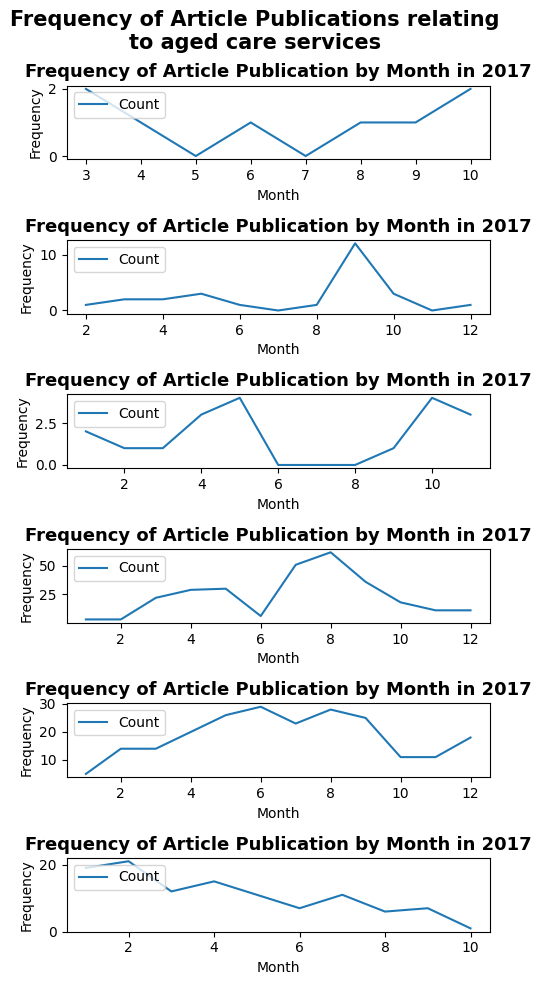

In [189]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6,  ncols=1)
vis_instantiation(fig, {}, {"name": "Frequency of Article Publications relating\nto aged care services", "size": 15})

year = final_scrape_df["Year"].min()
fig_subplotting_one(year, fig, year_count_list, [ax0, ax1, ax2, ax3, ax4, ax5], {"title": f"Frequency of Article Publication by Month in {year}", "y": ['Count'], "figsize": [5,10], "kind": "line"}, {"loc": 'upper left'})



Analyse the keyword occurrence frequency of published articles

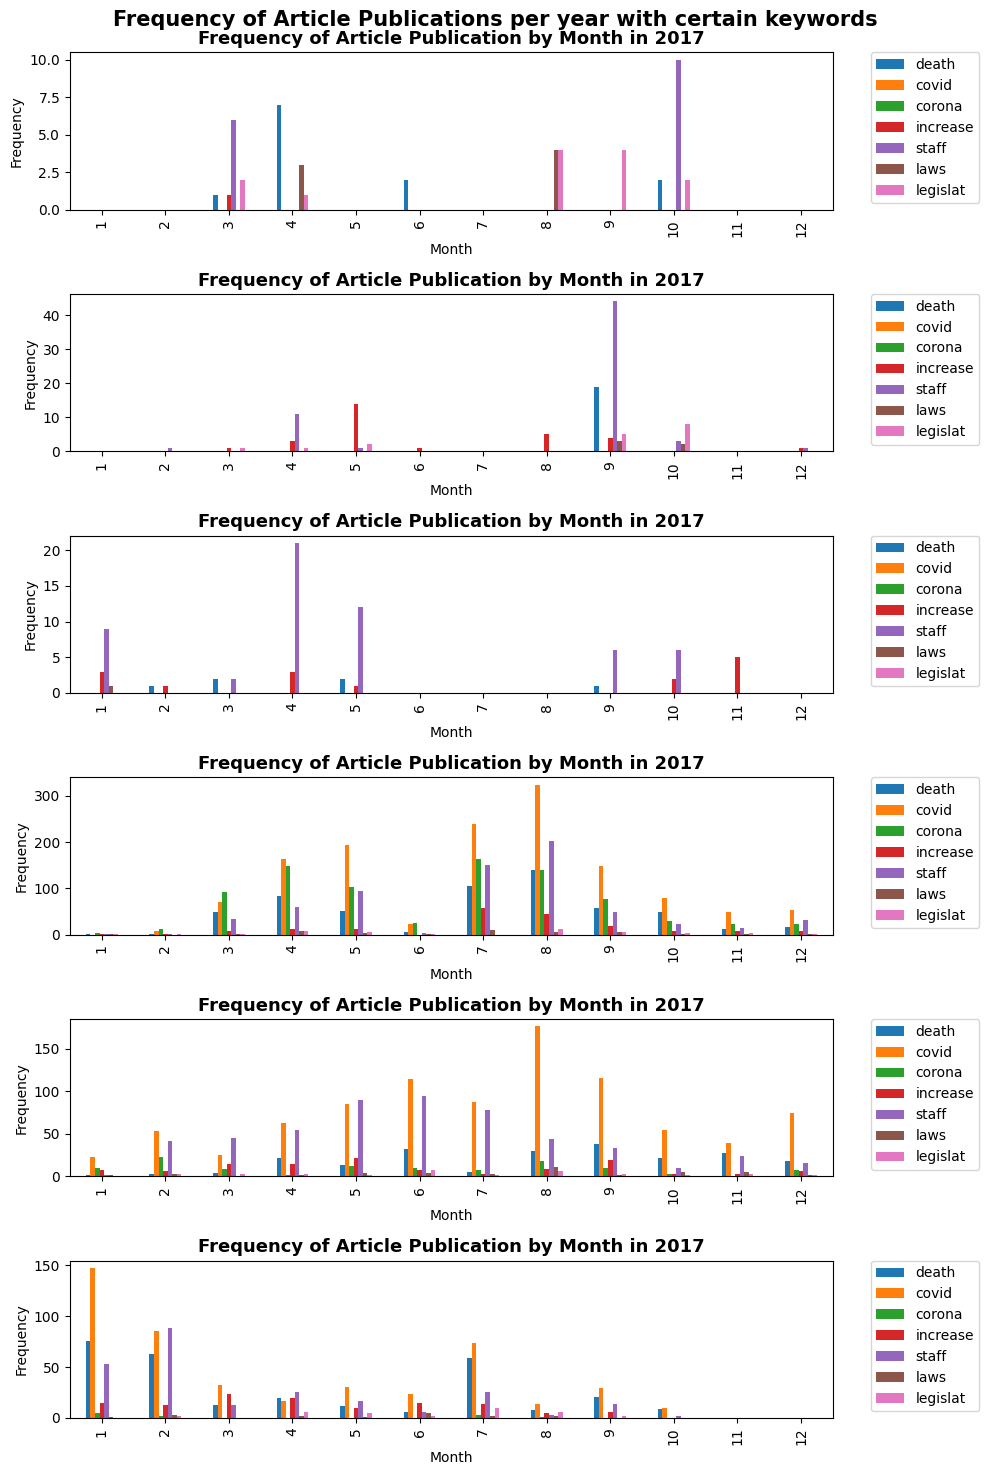

In [190]:
fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6,  ncols=1)
vis_instantiation(fig, {}, {"name": "Frequency of Article Publications per year with certain keywords", "size": 15})

year = final_scrape_df["Year"].min()
fig_subplotting_one(year, fig, year_keywords_count_list, [ax0, ax1, ax2, ax3, ax4, ax5], {"title": f"Frequency of Article Publication by Month in {year}", "y": ["death", "covid", "corona", "increase", "staff", "laws", "legislat"], "figsize": [10,15], "kind": "bar"}, {"bbox_to_anchor": [1.05, 1], "loc": 'upper left', "borderaxespad": 0.})

Analyse the relevant questions in the survey results

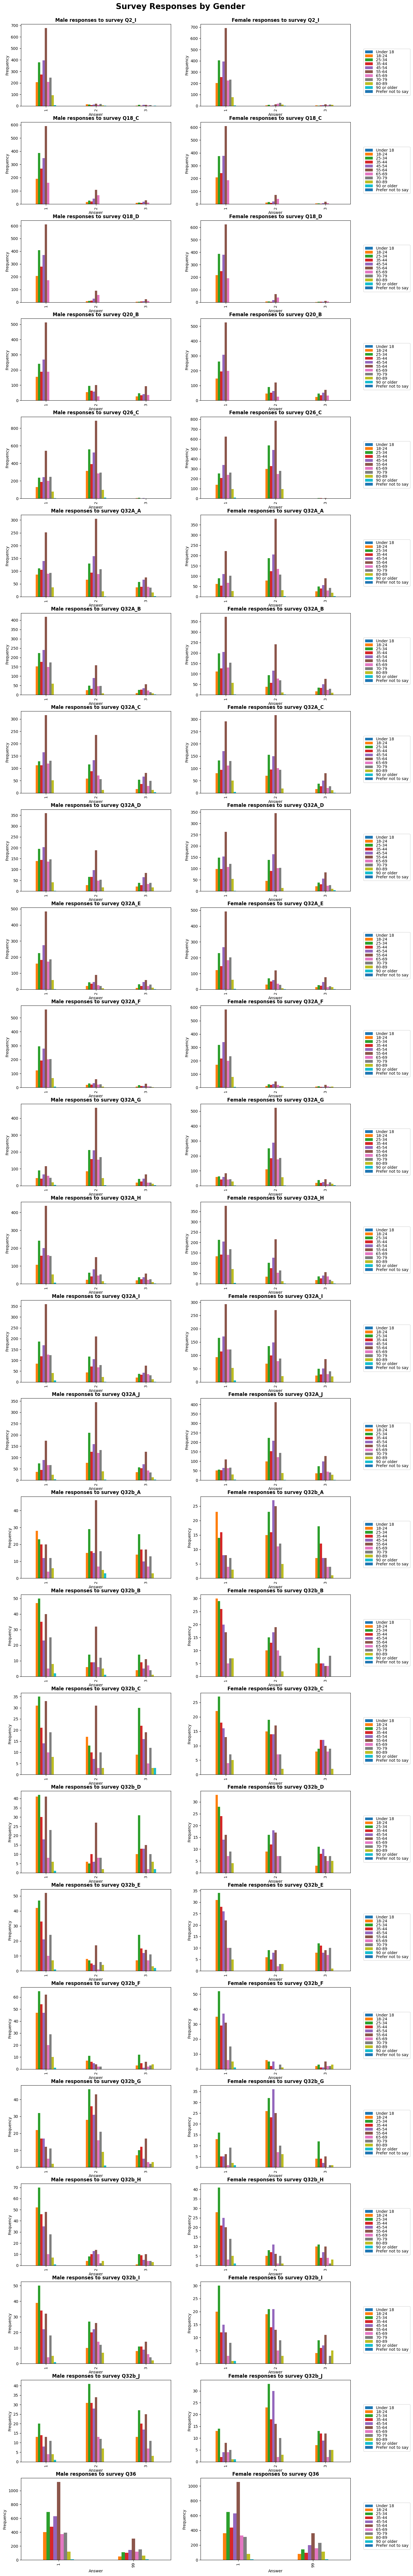

In [191]:
questions_list = ["Q2_I", "Q3", "Q18_C", "Q18_D", "Q20_B", "Q26_C", "Q27", "Q32A_A", "Q32A_B", "Q32A_C", "Q32A_D", "Q32A_E", "Q32A_F", "Q32A_G", 
                "Q32A_H", "Q32A_I", "Q32A_J", "Q32b_A", "Q32b_B", "Q32b_C", "Q32b_D", "Q32b_E", "Q32b_F", "Q32b_G", "Q32b_H", "Q32b_I", "Q32b_J", "Q36"]

fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7), (ax8, ax9), (ax10, ax11), (ax12, ax13), (ax14, ax15), (ax16, ax17), (ax18, ax19), 
    (ax20, ax21), (ax22, ax23), (ax24, ax25), (ax26, ax27), (ax28, ax29), (ax30, ax31), (ax32, ax33), (ax34, ax35), (ax36, ax37), (ax38, ax39), 
    (ax40, ax41), (ax42, ax43), (ax44, ax45), (ax46, ax47), (ax48, ax49), (ax50, ax51)) = plt.subplots(nrows=26, ncols=2)

vis_instantiation(fig, {"left": 0.125, "bottom": 0.1, "right": 0.9, "top": 18, "wspace": None, "hspace": None, "y": 18.15}, {"name": "Survey Responses by Gender", "size": 20})

fig_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20, ax21, 
    ax22, ax23, ax24, ax25, ax26, ax27, ax28, ax29, ax30, ax31, ax32, ax33, ax34, ax35, ax36, ax37, ax38, ax39, ax40, ax41, ax42, ax43, ax44, 
    ax45, ax46, ax47, ax48, ax49, ax50, ax51]

fig_count = 0
if len(survey_analysis_df_list) > 0:
    for index in range(len(survey_analysis_df_list[0])):
        if len(survey_analysis_df_list[0][index]) > 3:
            continue
        
        fig_list[fig_count].set_title(f"Male responses to survey {questions_list[index]}", fontweight="bold", size=12)
        survey_analysis_df_list[0][index].plot("Answers", ["Under 18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-69", "70-79", "80-89", "90 or older", "Prefer not to say"], 
                                                ax=fig_list[fig_count], kind="bar", xlabel="Answer", ylabel="Frequency", figsize=(15,5))
        fig_list[fig_count].legend().remove()
        fig_count += 1

        fig_list[fig_count].set_title(f"Female responses to survey {questions_list[index]}", fontweight="bold", size=12)
        survey_analysis_df_list[1][index].plot("Answers", ["Under 18", "18-24", "25-34", "35-44", "45-54", "55-64", "65-69", "70-79", "80-89", "90 or older", "Prefer not to say"], 
                                                ax=fig_list[fig_count], kind="bar", xlabel="Answer", ylabel="Frequency", figsize=(15,5))
        fig_list[fig_count].legend(ncol=1, labelspacing=0., bbox_to_anchor=(1.4, .7), borderaxespad=0.)
        fig_count += 1


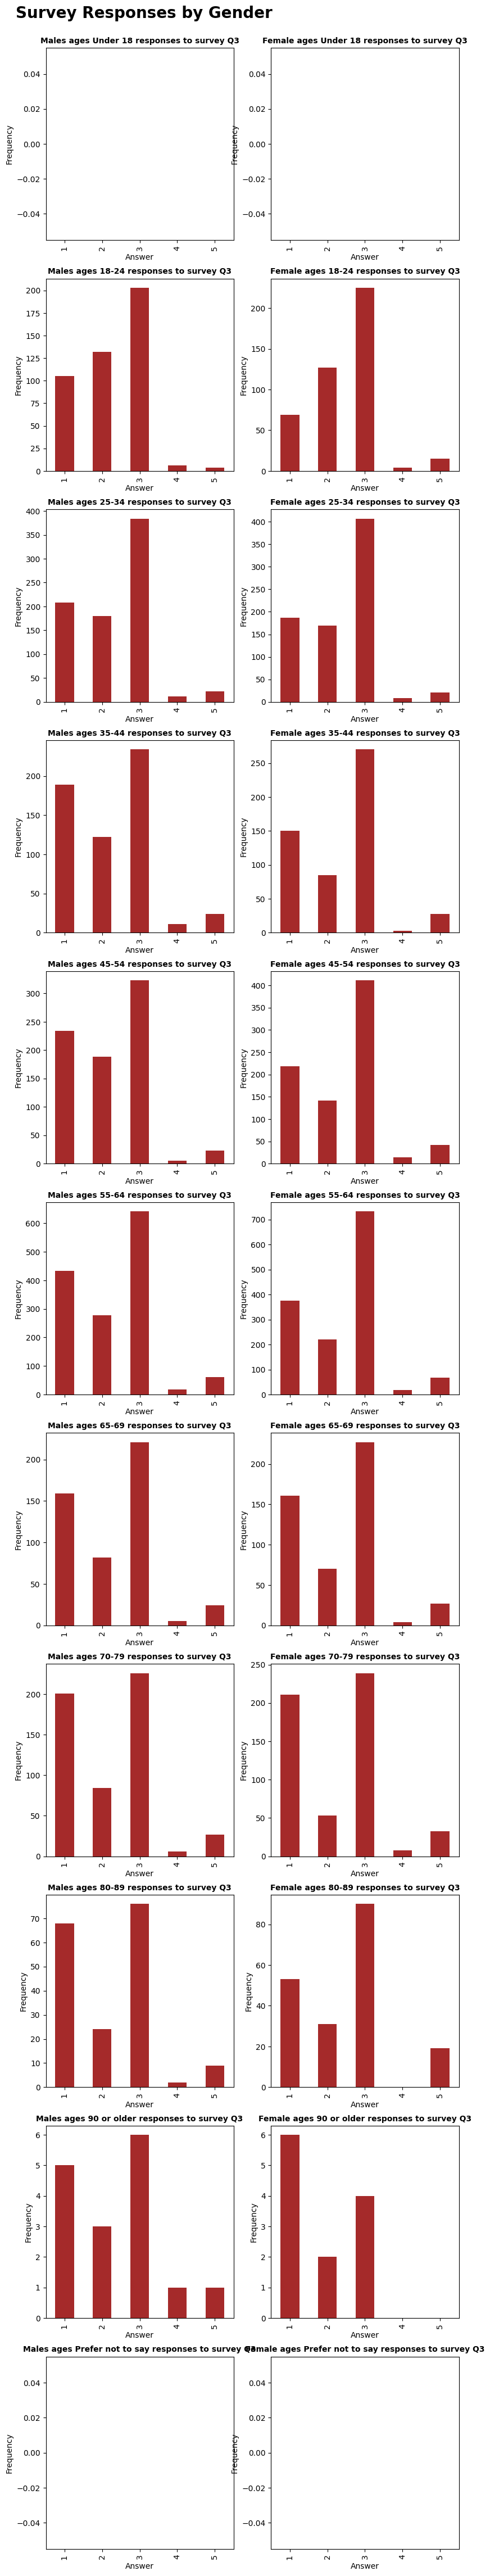

In [192]:
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7), (ax8, ax9), (ax10, ax11), (ax12, ax13), (ax14, ax15), (ax16, ax17), (ax18, ax19), 
    (ax20, ax21)) = plt.subplots(nrows=11, ncols=2)
fig.suptitle("Survey Responses by Gender", fontweight="bold", size=20, y=9.15)
fig.subplots_adjust(left=0.25, bottom=0.1, right=1.3, top=9, wspace=None, hspace=None)

fig_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20 , ax21]

fig_count = 0
keys_list = [n for n in survey_analysis_df_list[0][1].keys()]
keys_list.pop(0)

for key in keys_list:
    
    fig_list[fig_count].set_title(f"Males ages {key} responses to survey Q3", fontweight="bold", size=10)
    survey_analysis_df_list[0][1].plot("Answers", key, ax=fig_list[fig_count], kind="bar", xlabel="Answer", ylabel="Frequency", figsize=(7,5), color='brown')
    fig_list[fig_count].legend().remove()
    fig_count += 1

    fig_list[fig_count].set_title(f"Female ages {key} responses to survey Q3", fontweight="bold", size=10)
    survey_analysis_df_list[1][1].plot("Answers", key, ax=fig_list[fig_count], kind="bar", xlabel="Answer", ylabel="Frequency", figsize=(7,5), color='brown')
    fig_list[fig_count].legend().remove()
    fig_count += 1

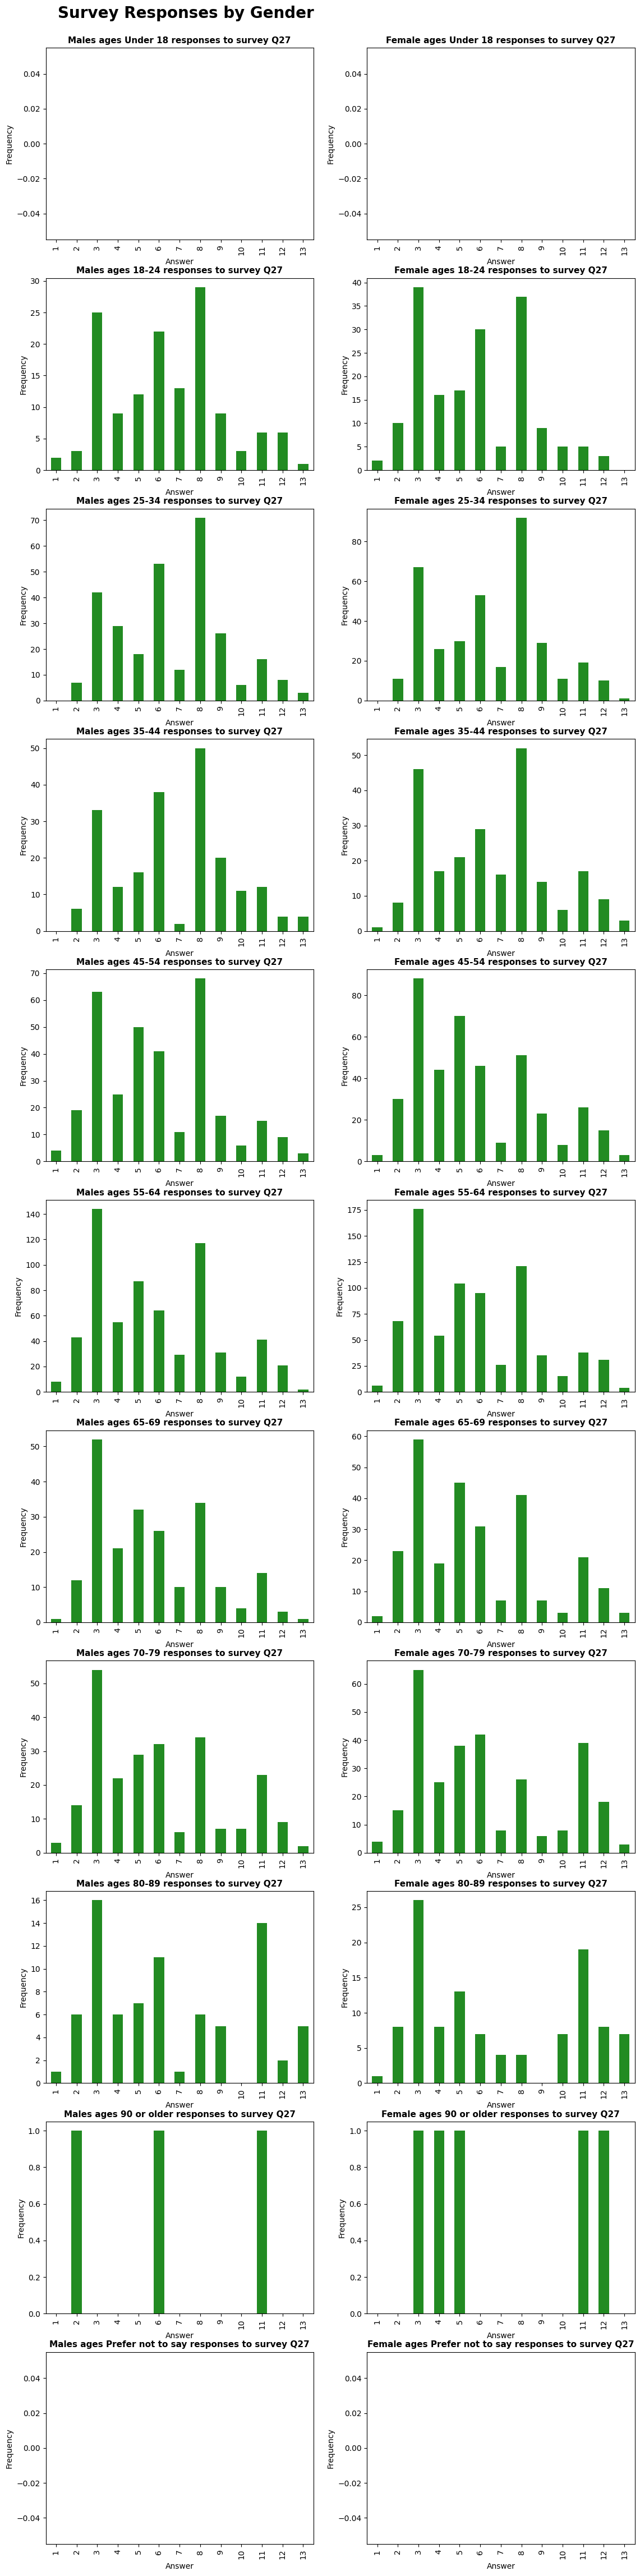

In [193]:
questions_list = ["Q3", "Q27", "Q36"]
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7), (ax8, ax9), (ax10, ax11), (ax12, ax13), (ax14, ax15), (ax16, ax17), (ax18, ax19), 
    (ax20, ax21)) = plt.subplots(nrows=11, ncols=2)
fig.suptitle("Survey Responses by Gender", fontweight="bold", size=20, y=9.15)
fig.subplots_adjust(left=0.25, bottom=0.1, right=1.3, top=9, wspace=None, hspace=None)

fig_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, ax17, ax18, ax19, ax20 , ax21]

fig_count = 0
keys_list = [n for n in survey_analysis_df_list[0][6].keys()]
keys_list.pop(0)

for key in keys_list:
    
    fig_list[fig_count].set_title(f"Males ages {key} responses to survey Q27", fontweight="bold", size=11)
    survey_analysis_df_list[0][6].plot("Answers", key, ax=fig_list[fig_count], kind="bar", xlabel="Answer", ylabel="Frequency", figsize=(10,5), color='forestgreen')
    fig_list[fig_count].legend().remove()
    fig_count += 1

    fig_list[fig_count].set_title(f"Female ages {key} responses to survey Q27", fontweight="bold", size=11)
    survey_analysis_df_list[1][6].plot("Answers", key, ax=fig_list[fig_count], kind="bar", xlabel="Answer", ylabel="Frequency", figsize=(10,5), color='forestgreen')
    fig_list[fig_count].legend().remove()
    fig_count += 1

#### Internal Visualisations:

##### Create functions to complete repetitive code (in this case, visualising the data) 

In [194]:
def internal_vis_instantiation(fig, fig_para_map, plot_title_map):   

    if len(fig_para_map) > 0:
        fig.suptitle(plot_title_map["name"], fontweight="bold", size=plot_title_map["size"], y=fig_para_map["y"])
        fig.subplots_adjust(left=fig_para_map["left"], bottom=fig_para_map["bottom"], right=fig_para_map["right"], top=fig_para_map["top"], wspace=fig_para_map["wspace"], hspace=fig_para_map["hspace"])
    
    else:
        fig.suptitle(plot_title_map["name"], fontweight="bold", size=plot_title_map["size"]) 

    return fig
 
def internal_fig_subplotting_one(fig, df, fig_list, fig_parameters, legend_map):
    title_list = ["remoteness", "program type", "organisation type", "service size", "operational places"]

    for count, df in enumerate(df):
        keys_list = [n for n in df.keys()]
        keys_list.remove(fig_parameters["x"])

        fig_list[count].set_title(f'Internal data "{title_list[count]}" column aggregation per {fig_parameters["xlabel"].lower()}', fontweight="bold", size=13) 
        df.plot(fig_parameters["x"], keys_list, ax=fig_list[count], xlabel=fig_parameters["xlabel"], ylabel=fig_parameters["ylabel"], kind=fig_parameters["kind"], figsize=(fig_parameters["figsize"][0],fig_parameters["figsize"][1])) 
        
        if len(legend_map) > 1:
            fig_list[count].legend(bbox_to_anchor=(legend_map["bbox_to_anchor"][0],legend_map["bbox_to_anchor"][1]), loc=legend_map["loc"], borderaxespad=legend_map["borderaxespad"])
        else:
            fig_list[count].legend(loc=legend_map["loc"])

##### Code utilising the created functions to acquire the relevant data for visualisation purposes

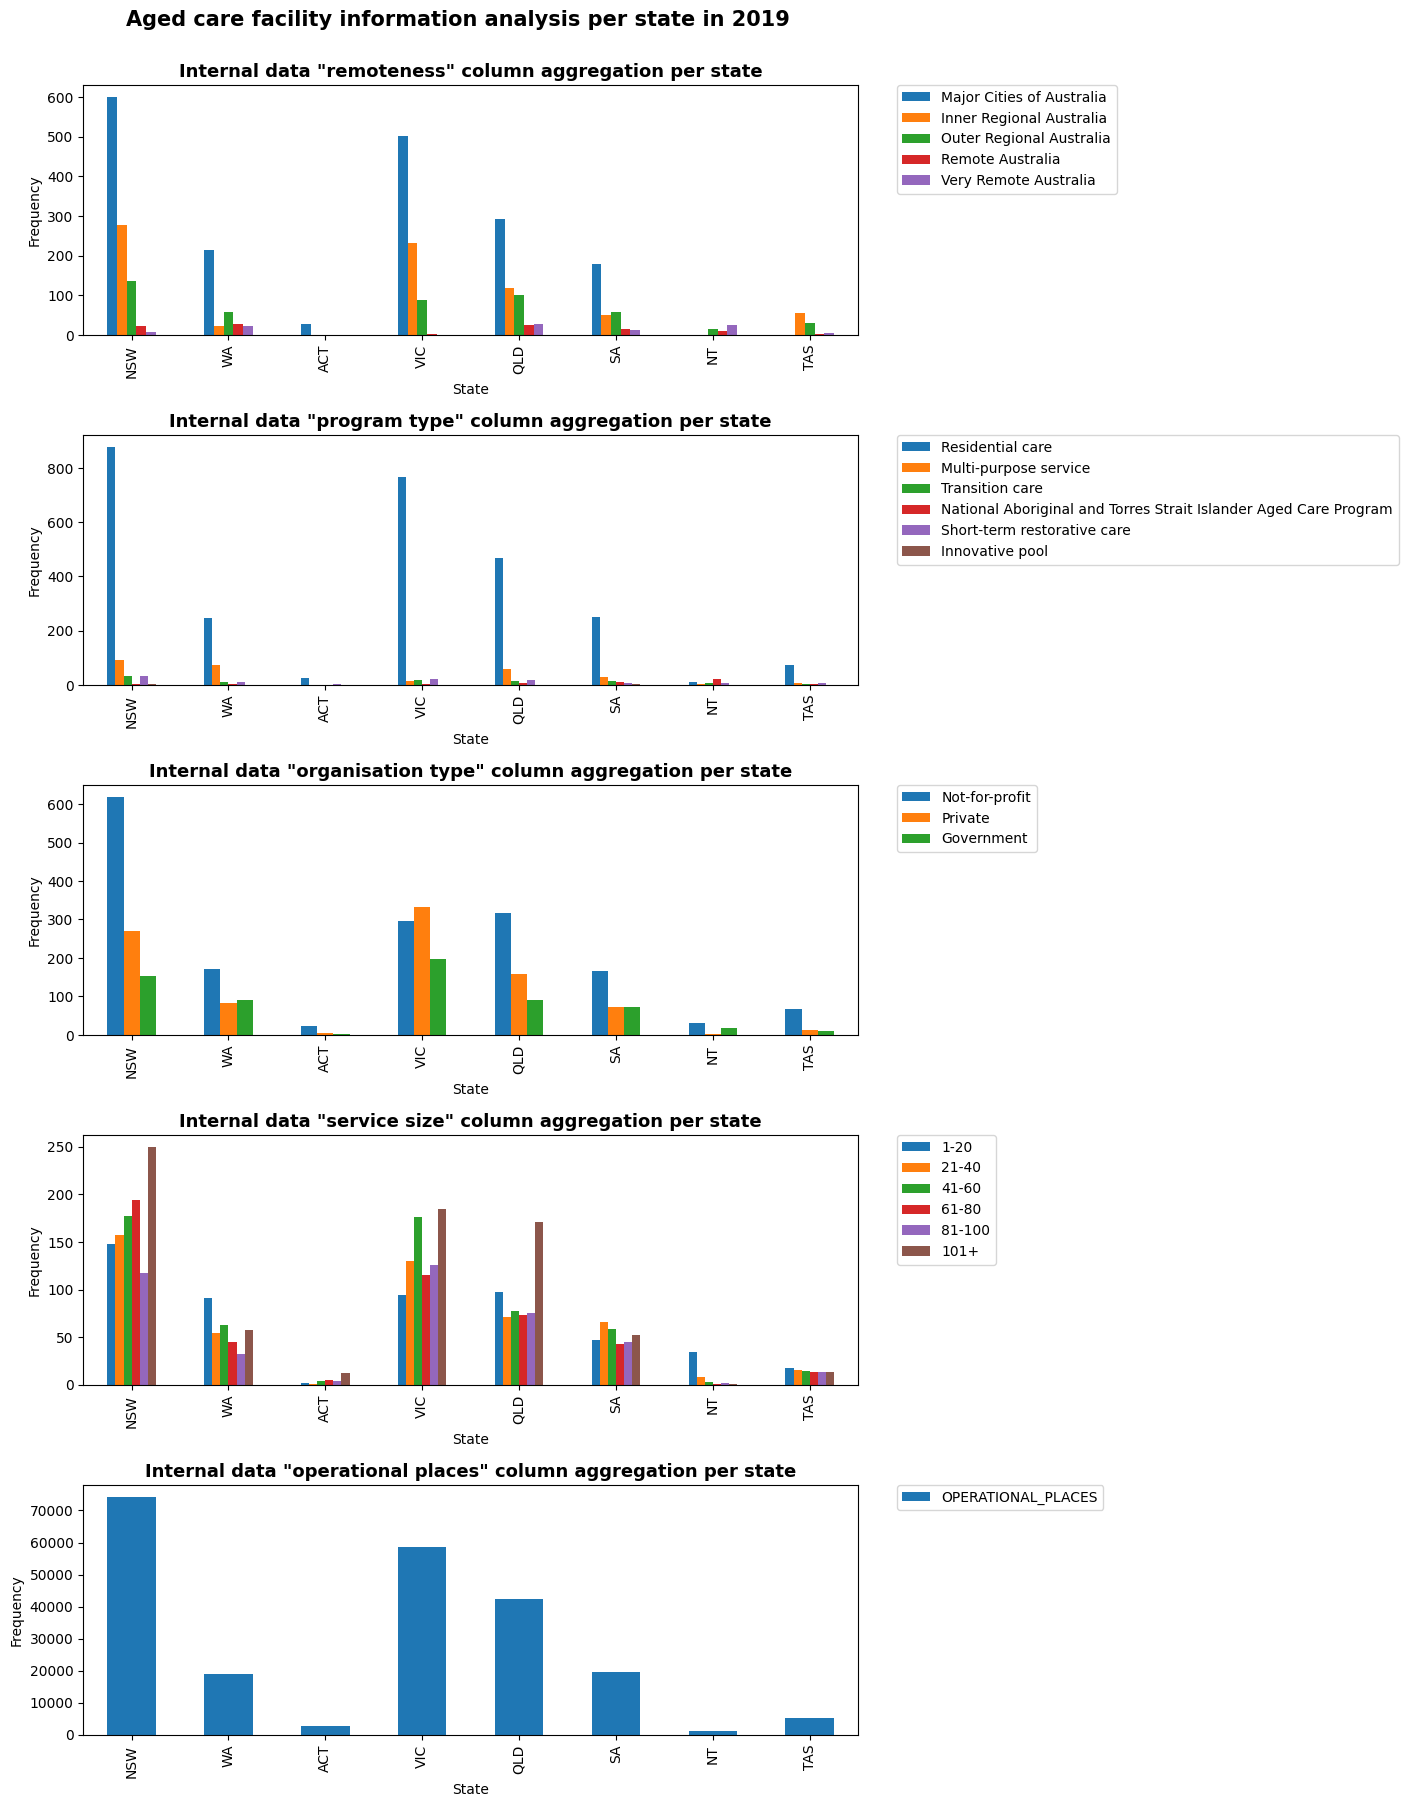

In [195]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5,  ncols=1)
internal_vis_instantiation(fig, {"left": 0.125, "bottom": 0.1, "right": 0.9, "top": 1.2, "wspace": None, "hspace": .4, "y": 1.25}, {"name": "Aged care facility information analysis per state in 2019", "size": 15})

internal_fig_subplotting_one(fig, gen_2019_df_list[0], [ax0, ax1, ax2, ax3, ax4], {"x": "STATE", "xlabel": "State", "ylabel": "Frequency", "figsize": [10,15], "kind": "bar"}, {"bbox_to_anchor": [1.05, 1], "loc": 'upper left', "borderaxespad": 0.})

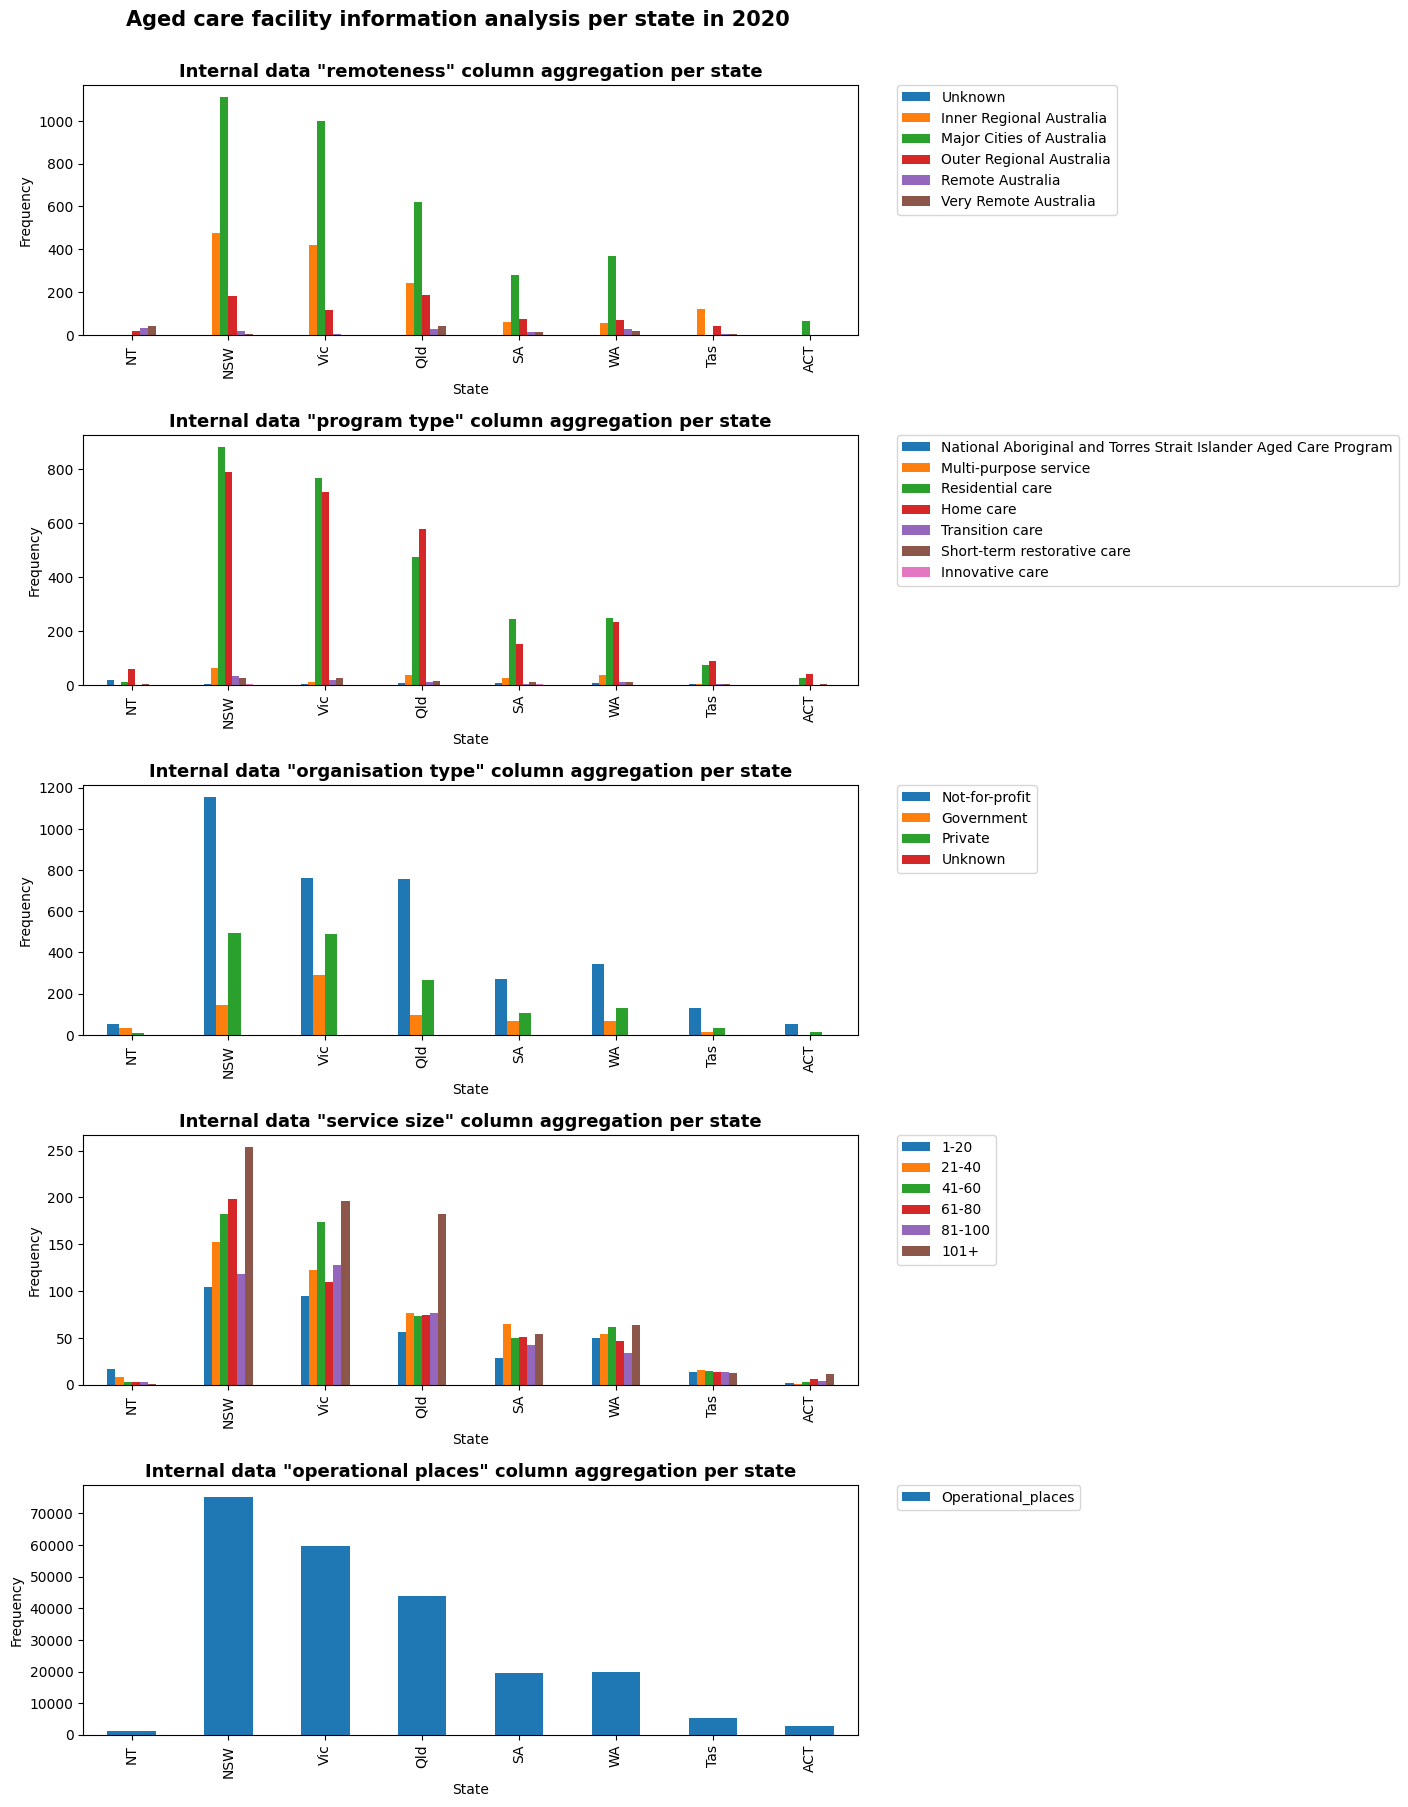

In [196]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5,  ncols=1)
internal_vis_instantiation(fig, {"left": 0.125, "bottom": 0.1, "right": 0.9, "top": 1.2, "wspace": None, "hspace": .4, "y": 1.25}, {"name": "Aged care facility information analysis per state in 2020", "size": 15})

internal_fig_subplotting_one(fig, gen_2020_df_list[0], [ax0, ax1, ax2, ax3, ax4], {"x": "State", "xlabel": "State", "ylabel": "Frequency", "figsize": [10,15], "kind": "bar"}, {"bbox_to_anchor": [1.05, 1], "loc": 'upper left', "borderaxespad": 0.})

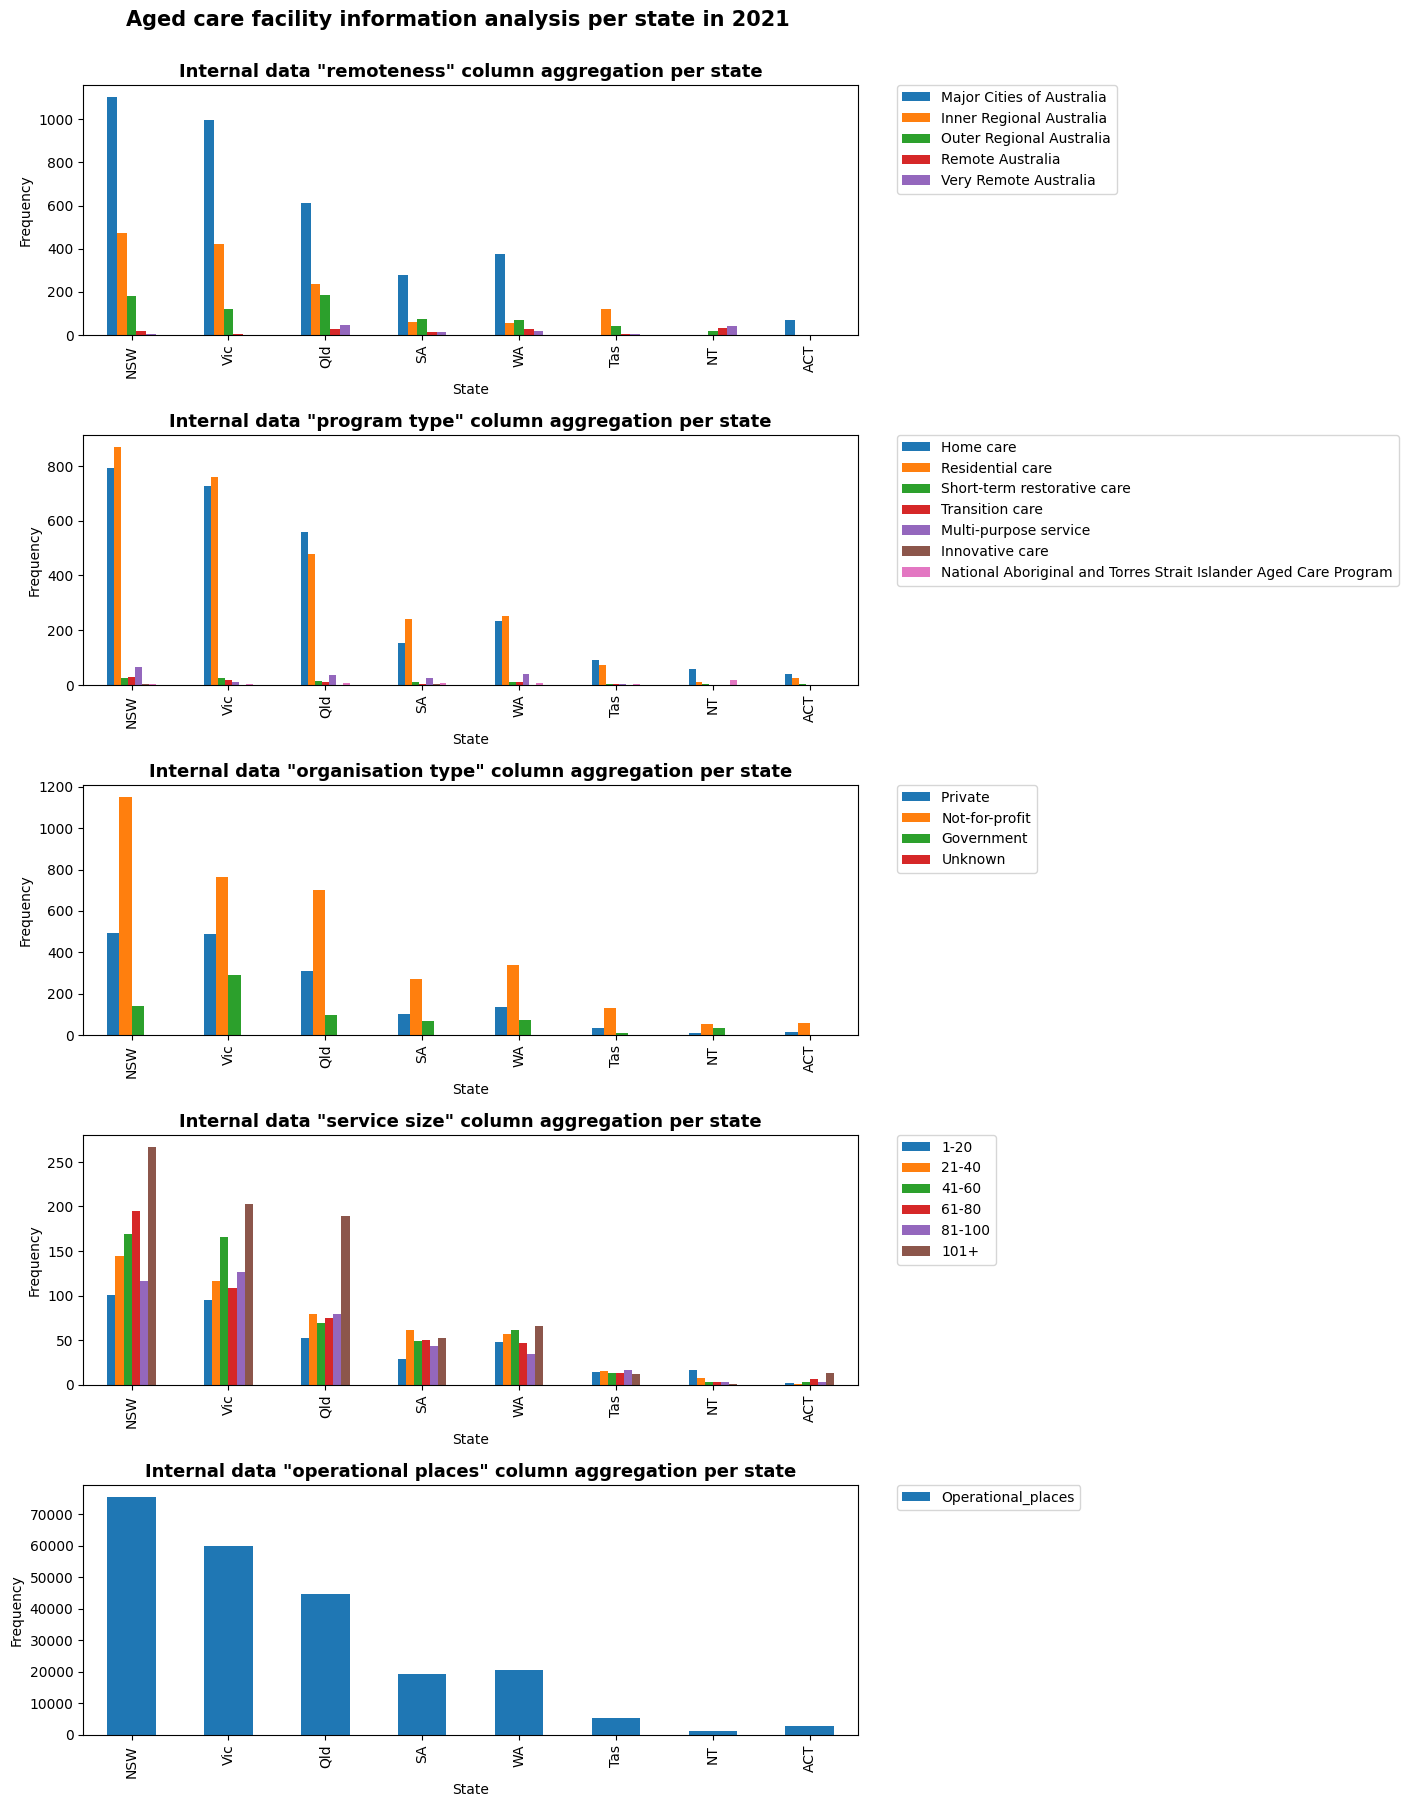

In [197]:
fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(nrows=5,  ncols=1)
internal_vis_instantiation(fig, {"left": 0.125, "bottom": 0.1, "right": 0.9, "top": 1.2, "wspace": None, "hspace": .4, "y": 1.25}, {"name": "Aged care facility information analysis per state in 2021", "size": 15})

internal_fig_subplotting_one(fig, gen_2021_df_list[0], [ax0, ax1, ax2, ax3, ax4], {"x": "State", "xlabel": "State", "ylabel": "Frequency", "figsize": [10,15], "kind": "bar"}, {"bbox_to_anchor": [1.05, 1], "loc": 'upper left', "borderaxespad": 0.})

### Findings:

#### External:

**The overall concern:**

The overall concern the external data is looking to analyse is any opportunities or threats to our client regarding one of the following areas: <br />
-	the community’s understanding of the needs of the sector  <br />
-	the potential impact of government action <br />
-	their own influence sphere within the sector <br />

**What data was used:**

To analyse these primary areas, a variety of data was used. This data was primarily sourced from the guardian API as it is an internationally trusted and utilised news source that contains a large amount of articles on similarly numerous topics. From the guardian API, we sourced every article from 2017 onwards on one of the two following topics: <br />
-	Aged care facilities <br />
-	Residential aged care <br />

These topics are quite self-explanatory as our client is a not-for-profit residential aged care facility. We searched the API for these two search terms independently as this would provide a wider range of relevant articles for analysis. Additionally, we elected to utilise data from an anonymised survey of unrelated participants. This survey consisted of forty questions centred around aged care facilities and the community's understanding of the sector.


**How the data was analysed:**

The analysis performed using the data consisted of three main steps. The first step involved identifying the overall topic and retrieving this data from the guardian API. Once all the data was retrieved, it was placed into a data frame for further analysis. The frequent use of data frames achieves two main goals, being persistent data storage under variable names for easy accessibility, and a visually appealing medium for viewing the data. After the articles were acquired from the API, HTML scraping was conducted to acquire the titles, subtitles, and body text of all acquired articles. The same process was completed for the data in the survey results.

The second step involved analysing the data for any immediate underlying trends and preparing it for visualisation purposes. This was completed by searching through the scraped titles, subtitles, and body text for relevant keywords, and creating a new data frame for every article containing the date of the article, the title, subtitle, and body of the article, and the total occurrence frequency of each keyword. Individualising the output results of each keyword allows for an easier time analysing each keyword specifically or analysing keyboards against each other to identify a common trend. To analyse the data from the survey, a slightly different process was performed. Firstly, questions relating to the overall business concern were identified. Using these questions, a list of data frames was created containing the results of the questions broken up do male and female responses. These lists were then concatenated into one overall list for accessibility sake. It was identified in this step that in the final relevant question (Q36), the responses given were a percentage range on the amount that aged care facilities for government funded. However, a response of one indicated that they were not government funded, and a responsive 99 indicated that the participant was unsure. It was found that every single participant both male and female only responded either one or ninety-nine. Therefore, for visualisation pragmatism, the data frame was stripped to only contain the amount of results for a response of one or 99.

The last step of analysis involved visualising the data. The two types of graphs used were line graphs and bar graphs. Line graphs were strictly used to visualise the frequency of article publications relating to aged care services per year. Bar graphs were heavily utilised when analysing multiple pieces of data against each other. An example of this is the first bar graph created, where it shows for each month (per year) the occurrence frequency of keywords in published articles 

**What do the visualisations tell us:** 

Looking at the first graph (frequency of article publications relating to aged care services), an interesting trend can be identified. Firstly, articles on this topic were relatively uncommon in 2017, 2018, and 2019 where the count peaked at around 10 articles. Interestingly in these three years, and increase can be identified from around the 7th month onwards. However due to the limited data, no concrete conclusion can be drawn. From 2020 onwards, articles on this topic became much more frequently occurring with the potential cause of this being identified in the next set of graphs. However, in both 2020 and 2021, there still remained a spike in article publication around the eight month. This could be for two reasons: 
-	the first reason could be the same reason behind the sudden increase from the seventh month onwards in 2017, 2018, and 2019. 
-	the second reason is uncovered in the next graph showcasing the keywords. 

Finally, the 2022 results show a decline in article publication as the progresses.

In the second set of graphs, the articles published were analysed using the following keywords:
-	Death
-	Covid
-	Corona
-	Increase
-	Staff
-	Laws
-	Legislat (was specifically legistlat to cover both legislate, legislative, and legislature)

Death, increase, and staff was chosen as frequent appearances of death relating to aged care services could heavily negatively impact the communities perception of the sector. Whereas an article containing the words increase or staff would not be using these words positively, therefore leading to a harmed community perception. Covid and corona are self-explanatory, and laws/legislat were chosen to potentially identify any legal or governmental impacts on aged care.
 
Obviously as the covid-19 pandemic hit media in 2020, there were no results for either covid or corona. In the years prior to the pandemic, the front running keywords were staff and death. Every other identified keyword did not have enough results to identify a trend. The keyword staff appeared primarily between the third and fifth months, and the 9th and 11th months. The repetitive popularity in autumn and spring specifically could be due to a number of reasons:
-	Staffing shortages occur at these times specifically as new workers starting at the start or middle of the year would have been working for a few months, and could be leaving the sector after this amount of experience for internal reasons
-	Hiring waves occur at these times of year of the year, therefore articles on this sector would be frequently talking about staff
-	Riots or protests could frequently occur at these times of the year

However, due to limited information, no clear conclusion can be reached as to which reason is correct.

When analysing the graphs containing the results from 2020 onwards, it is clear that articles containing the keyword covid heavily dominated. Prior to 2020, the highest frequency of any keyword was forty. However in 2020 and 2021, the lowest frequency of covid was roughly 40. Furthermore, in 2021 the staff keyword had a similar trend to covid as can be seen from the 2nd to the 7th month. Therefore it can be assumed that at the start of the pandemic (2020) mainstream media was commonly mentioning the pandemic in relation to aged care services, then as the pandemic progressed (2021) staffing shortages or problems relating to staff were commonly mentioned along with the pandemic (showing that the staffing problems were directly correlated to the pandemic), and finally as the pandemic started fizzling out (2022), it became far less commonly occurring in the media, as seen by the continual downward trend.

The final three sets of graphs are all in relation to the external survey provided. Although a large number of questions when visualised, they are all relevant and each contain interesting information. The acquired information is as follows:

-	2I
    - Vast majority of participants both male and female agree that society has an obligation to care for older people
-	3
    - Participants across all genders up to the age of sixty-nine agree that the government should be paying for aged care, however in ages seventy onwards, some agree that the government should pay, whereas others agree that the older person themselves should pay
-	18c/d
    - Vast majority of participants both male and female agree that showering, dressing, toilet, and medication assistance are all particularly important services provided by age care facilities
-	20b
    - Vast majority of participants both male and female think that they will be healthy enough to be able to care for themselves in their 70s and 80s
-	26c
    - Somewhat even split from participant responses on whether or not they know someone who receives homecare support
-	27
    - Across all ages and genders, the common three responses are that the participants visits the person they know (who receives personal support) either once a week, several times a week, or several times a year. The exact preference of these responses varies between eight groups 
-	32:
    - If the participant has visited an aged care facility, these are the common understandings of said facilities:
        - Food quality received is highly contested
        - Facilities are safe
        - Highly contested over whether there are enough activities to entertain people
        - Somewhat contested over weather people in facilities receive the help they need on time
        - Agreed that the accommodation is comfortable and well maintained
        - Agreed that people in facilities are often lonely
        - Agreed that people in facilities do not have control over their own lives
        - Agreed that people have timely access to medical professionals and other health care
        - Somewhat contested over whether people in facilities are respected 
        - Agreed that people are not happy in facilities
    - If the participant has not visited an aged care facility, these are the common understandings of said facilities:
        - Indecisive over the food quality
        - Somewhat agree that people are safe in facilities
        - Indecisive over whether there are enough activities to keep people entertained
        - Somewhat agree that people receive the help they need on time
        - Agree that the accommodation is comfortable and well maintained
        - Agree that people in facilities are often lonely
        - Agree that people in facilities do not have control over their lives
        - Agreed that people have timely access to medical professionals and other health care
        - Indecisive over whether people in facilities are respected or not
        - Somewhat agree that people are not happy in facilities
-	36
    - Most participants agree that aged care facilities on not funded by the government

When analysing all the responses, noticeably clear trends can be seen. Firstly, it is evident that society understands the intrinsic value of aged care services however at the same time it is evident that participants do not wish to themselves be in said facilities (see q2i/q18/q20). Furthermore, participants agree that the government should be funding age care facilities, however the consensus is that age care facilities currently receive no funding (q3/q36). When coupling these results with the responses from q26/q27/q32, an interesting conclusion could be reached. As seen in question 32, common points of contention for facilities are the food quality, the limited amount of entertaining activities, access to required help (results from staffing issues), limited access to other members of society, and restricted control over their own lives. With the exception of access to other members of society and control over their own lives, participants seemed to agree that every point of contention can be immediately remedied with more funding. Thus, if more funding is acquired and these points are remedied, the societal perception of aged care facilities will likely heavily increase.

**Opportunities:**
-	As society understands the value of aged care services, this will make any further improvements more effective
-	Prove to society that aged care facilities are far better than currently understood
-	Can receive government funding (publicly as well) to improve the conditions of facilities

**Threats:**
-	Society has a clear discriminant view of aged care facilities
-	This ever-present view will limit the number of people willing to work in said facilities
-	People with a harshly negative view on facilities will be far less considerate of said facilities if they ever join one
-	Media presence of aged care facilities is related to events on the scale of a global pandemic

#### Internal:

**The overall concern:**

The overall concern the internal data is looking to analyse is any strengths or weaknesses to our client that could be used to impact one of the following areas
-	the community’s understanding of the needs of the sector
-	the potential impact of government action
-	their own influence sphere within the sector

**What data was used:**

To analyse these primary areas, data obtained internally (csv containing reports of aged care facilities) was acquired and analysed. These reports contain a range of useful information, such as (for each facility):
-	The state the facility is located in
-	The program type
-	The organization type
-	The service size (number of employees)
-	The operational places


**How the data was analysed:**

The analysis performed consisted of three main steps. The first step was simply importing the reports from 2019 onwards into data frames, then iterating over the data frames to make the data are more versatile and universally applicable for the analysis. An example of this is changing the operational places values into floats instead of strings.

The second step involved analysing the data, and creating a list of the resulting output data frames. These data frames consisted of an analysis of the following information column
-	Number of facilities of each remoteness type per state
-	Number of facilities of each program type per state
-	Number of facilities of each organization type per state
-	Number of facilities of each service size per state
-	Total number of operational places per state
This allowed for a clear understanding of the data, and immediately identifies any common underlying trends.

The final step involved visualising the data. Only one graph type was used, being bar graphs. As each analysis performed and visualisation is comparing different data points, bar graphs are very effective method of achieving this plus also keeping a high level of clarity.



**What do the visualisations tell us:** 

When looking at the graphs depicting the remoteness of facilities across every year, a clear trend can be identified. That is, in every state (excluding NT) the vast majority of facilities are in major cities of Australia. However, in the NT, there are no facilities in a ‘major city’. Additionally, there are almost no facilities in either remote Australia or very remote Australia throughout every single state. This means that if someone is not in a major city of Australia, in a regional Australia, or in some cases auto regional Australia, they have extremely limited access to aged care services. 

Additionally, in 2019, nearly every single recorded facility provides solely residential care. In 2020 and 2021, nearly every facility is either a residential care or a home care facility. However, this means that if someone requires any service outside of home or residential care (for example, short term restorative care, transition care, multipurpose service, or innovative care), they have almost no options available to them.

Furthermore, in most every states in 2019, there appears to be a even split between not for profit, private, or government facilities. Notably NSW and QLD are majority not for profit facilities. However, in 2020 in 2021 every state contains a vast majority of not-for-profit facilities. Therefore, it can be assumed that government and private facilities either lost their funding or for any reason ceased to exist after 2019. However interestingly, across all three years and every state there seems to be an even split in the service size values. Thus, even though majority of facilities they came not for profit after 2019, their service sizes weren’t impacted.

Finally, NSW, Victoria, and QLD are consistently the top three states with the most operational places. This makes perfect sense as these three states are the three most populous throughout Australia, thus requiring the most amount of facilities.


**Strengths:**
-	high accessibility for aged care facilities in most populated states
-	most facilities are not for profit, therefore potentially increasing the public view as these facilities are not profiting from in need patients
-	high accessibility for facilities in major cities



**Weaknesses:**
-	incredibly limited accessibility outside of regional Australia (or in NT/SA/Tasmania)
-	almost no facilities providing services other than home care or residential care
-	no private or government facilities means limited funding, thus lowers the quality of service provided

## Conclusion

### Recommendations:

**S and O:**
-	Improve services provided in major cities to impact as many people as possible to prove to society that aged care facilities are much better than is currently perceived
-	Provide more facilities in popular states to prove to society that aged care facilities are much better than is currently perceived

**S and T:**
-	Increase public knowledge that nearly every facility is not for profit to improve the current discriminant perception
-	Increasing public knowledge will also increase the current media presence, thus removing the current requirement of an event such as a pandemic (for high media presence), and will spark a conversation in the media about current problems (outside of their control) and solutions for aged care facilities

**W and O:**
-	Try to humanise aged care services to prove that the widely acknowledged problems are out of their control (with current funding)
-	Receiving government funding to improve the service quality, and increase awareness of improved facility quality
-	Increasing accessibility of facilities outside of regional Australia or in states aside from QLD/NSW/VIC will further improve societies perception

**W and T:**
-	Try to humanise aged care services to prove that the current perception is unfair given the funding amounts, staffing issues, etc. 
-	Increasing accessibility of facilities outside of regional Australia or in states aside from QLD/NSW/VIC To improve the current pessimist view of aged care facilities
-	Increasing accessibility of facilities outside of regional Australia or in states aside from QLD/NSW/VIC to increase the amount of people able to and willing to work in said facilities


**Recommendations:**
-	Increase amount of facilities outside of regional Australia and in states aside from Queensland, NSW, or Vic
    - will improve any negative societal perceptions based on accessibility problems
-	increase accessibility of services aside from home care and residential care
-	receive government funding to improve service quality. Further:
    - improved service quality will remedy both the current societal perception, and will result in more people willing to attend such facilities
    - improved societal perception well increase the number of people willing to work in aged care facilities
-	increase media presence
    - spark conversations on the current problems, their causes, and solutions
    - increase media awareness of the causes of such problems will likely which is the amount of societal criticism

### Limitations:

- Limited information into the makeup of each service center
- limited information on our client's organisation, hard to directly relate findings to our client